# ***Assignment 3 for Data Analysis 3***

Conducted by Ian Brandenburg and Zsófia Rebeka Katona

[GitHub Repo](https://github.com/Iandrewburg/DA3_Brandenburg/tree/main/Assignment_3)



Developing a predictive model to identify which small or medium-sized firms in the "Manufacture of computer, electronic, and optical products" industry might fail in 2015, based on their activity in 2014.

[**Data source**](https://osf.io/b2ft9/?view_only=):
Detailed company data from a middle-sized country in the European Union
All registered companies in 2005-2016 in three selected industries 
  (auto manufacturing, equipment manufacturing, hotels and restaurants)
This rich database was constructed for from multiple publicly available sources 
by Bisnode, a business data and anlytics company www.bisnode.com
for educational purposes

Dependent Variable - Dummy Variable for if the company defaulted or not

#### ***Import Libraries and Helper Functions***

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import patsy
import matplotlib.pyplot as plt
import os
import sys
from io import StringIO
from pathlib import Path
from plotnine import *
from mizani.formatters import percent_format
import ast
from patsy import dmatrices
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, auc, brier_score_loss, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance, PartialDependenceDisplay, partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeRegressor
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from sklearn.calibration import calibration_curve
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree


In [2]:
# Helper Functions

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def create_calibration_plot(data, file_name, prob_var, actual_var, y_lab, n_bins=10, breaks=None):
    prob_true, prob_pred = calibration_curve(data[actual_var], data[prob_var], n_bins=n_bins, strategy='uniform')
    
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.plot(prob_pred, prob_true, "s-", label="Model")
    plt.xlabel("Predicted probability")
    plt.ylabel(y_lab)
    plt.title("Calibration Plot")
    plt.legend()
    plt.grid(True)
    
    plt.savefig(file_name + ".png", dpi=300)
    plt.show()
    
def create_coef_matrix(X, model):
    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns),pd.DataFrame(model.coef_.flatten())], axis = 1
    )
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix.iloc[-1] = ['Intercept', model.intercept_.flatten()[0]]
    return coef_matrix

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = (ggplot(all_coords, aes(x='fpr', y='tpr')) +
            geom_line(color='blue', size=0.7) +
            geom_area(position='identity', fill='mediumaquamarine', alpha=0.3) +
            xlab("False Positive Rate (1-Specifity)") +
            ylab("True Positive Rate (Sensitivity)") +
            geom_abline(intercept=0, slope=1, linetype="dotted", color="black") +
            scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1.1, .1), expand=(0, 0.01)) +
            scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1.1, .1), expand=(0.01, 0)) +
            theme_bw())
    return plot

def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    # Assuming FP (False Positive cost) and FN (False Negative cost) are provided or defined earlier
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy['false_pos'] * FP + all_coords_copy['false_neg'] * FN) / all_coords_copy['n']
    
    t = optimal_threshold
    l = curr_exp_loss

    # Define colors for plotting
    line_color = 'blue'  # Line color for geom_line and geom_vline
    text_color = 'red'  # Color for annotations

    plot = (ggplot(all_coords_copy, aes(x='thresholds', y='loss')) +
            geom_line(color=line_color, size=0.7) +
            scale_x_continuous(breaks=np.arange(0, 1.1, 0.1)) +
            coord_cartesian(xlim=(0, 1)) +
            geom_vline(xintercept=t, color=line_color) +
            annotate('text', x=t - 0.01, y=max(all_coords_copy['loss']) - 0.4,
                     label=f"best threshold: {round(t, 2)}",
                     colour=text_color, angle=90, size=7) +
            annotate('text', x=t + 0.06, y=l,
                     label=str(round(l, 2)), size=7) +
            theme_bw())
    return plot


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks = np.arange(0, 1.1, 0.1)) +\
        scale_x_reverse(breaks = np.arange(0, 1.1, 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)


def data_sherlock(data):
    # Initialize a StringIO object to capture the output of df.info()
    buffer = StringIO()
    data.info(buf=buffer)
    data_info_str = buffer.getvalue()

    # Separator for clarity in output
    separator = "-"*50

    print(f"{separator}\nDataFrame Information Summary\n{separator}")

    # Number of rows
    rows_count = data.shape[0]
    print(f"\nRows Information\n{separator}\nTotal rows: {rows_count}")

    # Check for remaining null values
    null_count = data.isnull().sum().sum()
    print(f"\nNull Values Information\n{separator}\nTotal null values: {null_count}")

    # Check for remaining infinite values
    infinite_count = (data.replace([np.inf, -np.inf], np.nan).isna() & data.notna()).sum().sum()
    print(f"\nInfinite Values Information\n{separator}\nTotal infinite values: {infinite_count}")

    # Data types
    print(f"\nData Types\n{separator}")
    print(data.dtypes)

    # DataFrame Information captured from .info()
    print(f"\nDataFrame Detailed Information\n{separator}\n{data_info_str}")

    # Return a structured summary as a dictionary (optional)
    return {
        "rows_info": f"Total rows: {rows_count}",
        "null_info": f"Total null values: {null_count}",
        "infinite_info": f"Total infinite values: {infinite_count}",
    }



# ***1. Data Processing***
---

## 1.1 *Import Data Directly from GitHub*
---

In [3]:
data = pd.read_csv('https://github.com/Iandrewburg/DA3_Brandenburg/raw/main/Assignment_3/cs_bisnode_panel.csv')
data.head()

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1001034.0,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1001034.0,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1001034.0,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1001034.0,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333


In [4]:
# Run the data_sherlock dataframe inspector function that we so gloriously created
data_sherlock(data)

--------------------------------------------------
DataFrame Information Summary
--------------------------------------------------

Rows Information
--------------------------------------------------
Total rows: 287829

Null Values Information
--------------------------------------------------
Total null values: 2889125

Infinite Values Information
--------------------------------------------------
Total infinite values: 0

Data Types
--------------------------------------------------
comp_id                 float64
begin                    object
end                      object
COGS                    float64
amort                   float64
curr_assets             float64
curr_liab               float64
extra_exp               float64
extra_inc               float64
extra_profit_loss       float64
finished_prod           float64
fixed_assets            float64
inc_bef_tax             float64
intang_assets           float64
inventories             float64
liq_assets              float

{'rows_info': 'Total rows: 287829',
 'null_info': 'Total null values: 2889125',
 'infinite_info': 'Total infinite values: 0'}

## 1.2 *Label Engineering*

In [5]:
# Set the index to the columns of interest
data = data.set_index(["year", "comp_id"])

# Perform the unstack operation, which will automatically introduce NaNs for missing combinations
data = data.unstack().stack(dropna=False)

# Reset the index to make 'year' and 'comp_id' regular columns again
data = data.reset_index()

# Note: The unstack() and stack(dropna=False) operations introduce NaNs for missing entries automatically.


In [6]:
# Generate status_alive; if sales are larger than zero and not-NA, then firm is alive
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)


# It defaults in two years if there are sales in this year but no sales two years later
# Status_in_two_years: data.groupby('comp_id')['status_alive'].shift(-2)
data["default"] = (
    (data["status_alive"] == 1)
    & (data.groupby("comp_id")["status_alive"].shift(-2) == 0)
).astype(int)


In [7]:
data['status_alive'].value_counts()

status_alive
0    318453
1    238491
Name: count, dtype: int64

In [8]:
data['default'].value_counts()

default
0    507577
1     49367
Name: count, dtype: int64

In [9]:
data['default'].describe()

count    556944.000000
mean          0.088639
std           0.284222
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: default, dtype: float64

This concludes that 311,016 firms defaulted and 245,928 firms stayed alive, and 2 years later, 274,393 will stay alive and 13,436 firms will default.

In [10]:
data['sales'].describe()

count    2.803920e+05
mean     5.042513e+05
std      3.861890e+06
min     -1.472559e+07
25%      5.295370e+03
50%      3.280741e+04
75%      1.210056e+05
max      1.110294e+08
Name: sales, dtype: float64

In [11]:
# Replacimg negative sales values with 1. This operation is done outside of 
# ...the `assign` method because it's a direct modification of the dataframe.
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)

# Adding new columns to the dataframe through the `assign` method.
data = data.assign(
    # Create a new column 'ln_sales'. If sales are greater than 0, calculate the natural logarithm of sales.
    # If sales are NaN, keep them as NaN. Otherwise, set to 0. This ensures that negative sales, 
    # ...if any existed before the first operation, now converted to 1, won't result in a math error.
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
    # Convert sales to millions by dividing by 1,000,000 for easier readability and analysis.
    sales_mil=data["sales"] / 1000000,
    # Similar to 'ln_sales', but this time applying the logarithm to the sales converted to millions. 
    # ...Handles NaN and non-positive values similarly.
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)

In [12]:
# Calculating the year-over-year change in the logarithm of sales (in millions) by subtracting 
# ...the previous year's value from the current year's value for each company.
data['d1_sales_mil_log']=data['sales_mil_log']-data.groupby('comp_id')['sales_mil_log'].shift(1)


In [13]:
# Calculating the age of each company by subtracting the founding year from the current year. 
# ...If the result is negative (which might happen due to data errors), set the age to 0.
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)

# Identifying new companies or those without a full year of balance sheet data. 
# ...Mark them with a 1, others with a 0. If 'age' is NaN, keep it as NaN.
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)

# For new companies, set the year-over-year change in log sales to 0. 
# ...This adjustment is for handling new entries or missing data appropriately.
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)

# If the year-over-year change in log sales is NaN, consider the company 
# ...as new and update the 'new' column accordingly.
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])

# Replacing NaN values in 'd1_sales_mil_log' with 0, ensuring the dataset 
# ...does not have missing values in this calculation.
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)

In [14]:
data['new'].describe()

count    556944.000000
mean          0.680936
std           0.466114
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: new, dtype: float64

This concludes that there are 556,944 new firms.

In [15]:
data.isna().sum()

year                         0
comp_id                      0
begin                   269115
end                     269115
COGS                    538687
amort                   277155
curr_assets             269246
curr_liab               269246
extra_exp               287644
extra_inc               287644
extra_profit_loss       286318
finished_prod           539459
fixed_assets            269246
inc_bef_tax             276552
intang_assets           269255
inventories             269246
liq_assets              269246
material_exp            277155
net_dom_sales           538687
net_exp_sales           538687
personnel_exp           277155
profit_loss_year        278999
sales                   276552
share_eq                269246
subscribed_cap          269246
tang_assets             270585
wages                   538961
D                       556944
balsheet_flag           269115
balsheet_length         269115
balsheet_notfullyear    269115
founded_year            325572
exit_yea

## 1.3 *Feature Engineering*
---

NOTE: I think we can delete the following 

Categorizing the industry codes into broader groups
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])

Checking out the industry codes using comp_id as a reference
data.groupby('ind2_cat').count()['comp_id']

### 1.3.1 *Adding more Firm Characteristics Variables*
---

In [16]:
# Adding more variables as firm characteristics
data["age2"] = data["age"] ** 2

# Grouping values for foreign_management as dummies 
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)

# Creating new columns for the categorical gender and and region variables
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")

### 1.3.2 Looking at financial variables
---

In [17]:
# Looking at financial variables and creating new financial ratios

# As assets cannot be negative: transforming the negative asset values to 0 and flagging them
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    287466
1.0       223
Name: comp_id, dtype: int64

In [18]:
# Tranforming the negative asset variables to 0
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])

In [19]:
# Generating the total assets balance sheet variable by adding up the intangible, current and fixed assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()

count    2.876890e+05
mean     5.980575e+05
std      2.623770e+07
min      0.000000e+00
25%      4.792593e+03
50%      2.024815e+04
75%      8.810741e+04
max      1.032471e+10
Name: total_assets_bs, dtype: float64

In [20]:
# Collecting the profit and loss names
pl_names = ['extra_exp',
            'extra_inc',
            'extra_profit_loss',
            'inc_bef_tax',
            'inventories',
            'material_exp',
            'profit_loss_year',
            'personnel_exp']

# Collecting the balance sheet names
bs_names = ['intang_assets',
            'curr_liab',
            'fixed_assets',
            'liq_assets',
            'curr_assets',
            'share_eq',
            'subscribed_cap',
            'tang_assets' ]

In [21]:
# Scaling the the pl_names elements by dividing them with sales and creating a new column for them
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

In [22]:
# Creating new columns for bs_names by dividing each specified column by total_assets_bs
for col in bs_names:
    # Assuming bs_names does not already include "_bs"
    new_col_name = f"{col}_bs"
    # Replacing Infinite and NaN values with 0 in the new column
    data[new_col_name] = data[col].div(data["total_assets_bs"]).replace((np.inf, -np.inf, np.nan), 0)
    
    # Set values to NaN where total_assets_bs is NaN
    data[new_col_name] = np.where(data["total_assets_bs"].isna(), np.nan, data[new_col_name])


In [23]:
# Creating new columns for bs_names by dividing each specified column by total_assets_bs
for col in bs_names:
    # Assuming bs_names does not already include "_bs"
    new_col_name = f"{col}_bs" 
    # Directly assigning the result of division, handling NaN in total_assets_bs inline
    data[new_col_name] = np.where(
        data["total_assets_bs"].isna(), 
        # If total_assets_bs is NaN, assign NaN
        np.nan, 
        # Handling division by zero by replacing NaN values resulting from division by zero with 0
        # ... and replacing Infinite values with 0
        data[col].div(data["total_assets_bs"], fill_value=0).replace((np.inf, -np.inf), 0)
    )

In [24]:
# Dividing all bs_names elements by total_assets_bs and creating new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    # Replacing Infinite values with 0
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# Getting Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )
    

### 1.3.3 *Creating flags and winsorizing tails*
---

`Winsorizing` is dropping extreme values, usually by setting a threshold at a certain percentile in the distribution, and replacing values beyond that threshold with the threshold value itself.

In [25]:
# Creating a list for the variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

# Creating a new column for values above 1, and leaving NaN values unchanged
data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
# Replacing values above 1 with 1
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
# Creating a column to flag error
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
# Replacing negative values with 0
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

In [26]:
# Pooling variables that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl",
         "inc_bef_tax_pl",
         "profit_loss_year_pl",
         "share_eq_bs"]

# Raplcing negative values with -1
data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
# Replacing values above 1 with 1
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
# Creating a column to flag errors
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
# Creating a column for the quadratic values
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)


In [27]:
# Dropping 'flag' columns with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)


### 1.3.4 *Defining additional financial ratios*
---

In [28]:
# Gross Profit Margin
data['gross_profit_margin'] = (data['sales'] - (data['material_exp'] + data['personnel_exp'])) / data['sales']

# Net Profit Margin
data['net_profit_margin'] = data['profit_loss_year'] / data['sales']

# Return on Equity (ROE)
data['return_on_equity'] = data['profit_loss_year'] / data['share_eq']

# Debt-Equity Ratio
# Note: we need to adjust 'curr_liab' to total liabilities if we have that information. Need to further investigate the data.
data['debt_equity_ratio'] = data['curr_liab'] / data['share_eq']

# Current Ratio
data['current_ratio'] = data['curr_assets'] / data['curr_liab']

# Quick Ratio
data['quick_ratio'] = (data['curr_assets'] - data['inventories']) / data['curr_liab']

# Return on Assets (ROA)
data['return_on_assets'] = data['profit_loss_year'] / data['total_assets_bs']


### 1.3.5 *Including some additional imputation*
---

In [29]:
# Calculating the CEO's age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)

# Capping and imputing the missing values for CEO age
data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)

# Creating a new binary column for young CEOs
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)


In [30]:
# Creating category type variables
data["urban_m"] = data["urban_m"].astype("category")
#data["ind2_cat"] = data["ind2_cat"].astype("category")
data["default_f"] = data["default"].astype("category")
data["default_f"] = data["default_f"].cat.rename_categories(["no_default", "default"])


### 1.3.6 *Handling the sales variable (target variable)*
---

In [31]:
# Squaring the log sales
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2

In [32]:
# Performing linear regression: deault on logarithmic sales and squared logarithmic sales
ols_s = smf.ols("default ~ sales_mil_log + sales_mil_log_sq", data=data).fit()
print(ols_s.summary())

                            OLS Regression Results                            
Dep. Variable:                default   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                 1.673e+04
Date:                Mon, 26 Feb 2024   Prob (F-statistic):               0.00
Time:                        21:09:45   Log-Likelihood:            -1.1139e+05
No. Observations:              280392   AIC:                         2.228e+05
Df Residuals:                  280389   BIC:                         2.228e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0370      0.001  

The OLS regression shown here displays the unconditional regression of sales on the probability of a company defaulting. The coefficients here suggest there is an association between the probability a company will default and sales. The log sales coefficient suggests that a deecrease in sales is associated with an increase in the probability that a company will default. This is statistically significant at the 1% threshold.  

In [33]:
##############################################################################

# We should write a few sentences about the coefficients --> can also be included in the doc

##############################################################################

### 1.3.7 *Change in sales*
---

*Note:* Graphs are not in the book! 

**NOTE: I THINK WE CAN DELETE THIS**

In [34]:
# lowess
data["d1_sales_mil_log"].describe()

count    556944.000000
mean          0.023417
std           0.870581
min         -13.815511
25%           0.000000
50%           0.000000
75%           0.000000
max          14.634809
Name: d1_sales_mil_log, dtype: float64

## 1.4 *Hold Out Sample*
---

The holdout sample is filtered to the following parameters: 

- `ind2` code is 26, representing the manufacture of computer, electronic, and optical products industr<
- `sales` is filtered to be from 1,000 to 10,000,000
- `year` is set to 2014

In [35]:
# It defaults in two years if there are sales in this year but no sales two years later
# Status_in_two_years: data.groupby('comp_id')['status_alive'].shift(-2)
data["default"] = (
    (data["status_alive"] == 1)
    & (data.groupby("comp_id")["status_alive"].shift(-1) == 0)
).astype(int)


In [36]:
# Filter the holdout sample 
hold_out_sample = data[(data['ind2'] == 26) &
                     (data['sales'] >= 1000) &
                     (data['sales'] <= 10000000) &
                     (data['year'] == 2014)]
hold_out_sample

,year,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,...,current_ratio,quick_ratio,return_on_assets,ceo_age,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,default_f,sales_mil_log_sq
417864,2014,6.538183e+06,2014-01-01,2014-12-31,NaN,1018.518494,17022.222656,3040.740723,0.0,0.0,...,5.598051,5.598051,0.203344,52.5,0,0,0,0,default,9.011847
417890,2014,8.416055e+06,2014-01-01,2014-12-31,NaN,425.925934,105740.742188,6918.518555,0.0,0.0,...,15.283726,13.489829,-0.027249,54.0,0,0,0,0,default,9.939450
417942,2014,1.242838e+07,2014-01-01,2014-12-31,NaN,0.000000,0.000000,9277.777344,0.0,0.0,...,0.000000,0.000000,-inf,52.0,0,0,0,0,default,30.507003
417989,2014,1.777654e+07,2014-01-01,2014-12-31,NaN,48.148148,142296.296875,164237.031250,0.0,0.0,...,0.866408,0.109056,0.010282,43.5,0,0,0,0,no_default,2.402822
417994,2014,1.862676e+07,2014-01-01,2014-12-31,NaN,5755.555664,95185.187500,45766.667969,0.0,0.0,...,2.079793,1.755847,0.053106,36.0,0,0,0,1,default,3.176648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463875,2014,4.593723e+11,2014-01-01,2014-12-31,NaN,0.000000,40740.742188,559.259277,0.0,0.0,...,72.847682,72.847682,0.272000,39.0,0,0,0,1,default,15.972916
463965,2014,4.610112e+11,2014-01-01,2014-12-31,NaN,429.629639,58781.480469,2651.851807,0.0,0.0,...,22.166201,18.601955,0.028824,55.0,0,0,0,0,no_default,6.270351
464018,2014,4.620594e+11,2014-01-01,2014-12-31,NaN,1111.111084,68274.070312,16211.111328,0.0,0.0,...,4.211560,3.291981,0.007774,61.0,0,0,0,0,no_default,7.099340
464032,2014,4.623300e+11,2014-01-01,2014-12-31,NaN,0.000000,17192.591797,7325.925781,0.0,0.0,...,2.346815,2.346815,0.068191,52.5,0,0,0,0,default,12.497002


In [37]:
# Overview the data with the data_sherlock function
data_sherlock(hold_out_sample)

--------------------------------------------------
DataFrame Information Summary
--------------------------------------------------

Rows Information
--------------------------------------------------
Total rows: 1037

Null Values Information
--------------------------------------------------
Total null values: 8599

Infinite Values Information
--------------------------------------------------
Total infinite values: 43

Data Types
--------------------------------------------------
year                    int64
comp_id               float64
begin                  object
end                    object
COGS                  float64
                       ...   
flag_high_ceo_age       int32
flag_miss_ceo_age       int32
ceo_young               int32
default_f            category
sales_mil_log_sq      float64
Length: 124, dtype: object

DataFrame Detailed Information
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 1037 entries, 417864 to 4640

{'rows_info': 'Total rows: 1037',
 'null_info': 'Total null values: 8599',
 'infinite_info': 'Total infinite values: 43'}

In [38]:
# Missing values in the holdout sample
print("MISSING VALUES FROM HOLDOUT SAMPLE")
print("-"*35)
to_filter = hold_out_sample.isnull().sum()
to_filter[to_filter > 0]

MISSING VALUES FROM HOLDOUT SAMPLE
-----------------------------------


COGS                            948
amort                             2
finished_prod                   950
material_exp                      2
net_dom_sales                   948
net_exp_sales                   948
personnel_exp                     2
wages                           949
D                              1037
founded_year                     31
exit_year                      1014
ceo_count                        31
foreign                          31
female                           31
birth_year                      114
inoffice_days                    31
gender                           31
origin                           31
region_m                          2
exit_date                      1012
labor_avg                       312
age                              31
age2                             31
foreign_management               31
gender_m                         31
m_region_loc                      2
material_exp_pl                   2
personnel_exp_pl            

### 1.4.1 *Hold Out Sample Summary Table*
---

In [39]:
hold_out_summary = {
    'Number of Firms': [hold_out_sample.shape[0]],
    'Mean Sales': [hold_out_sample['sales'].mean()],
    'Min Sales': [hold_out_sample['sales'].min()],
    'Max Sales': [hold_out_sample['sales'].max()],
    'Defaulted Firms': [hold_out_sample['default'].sum()],
    'Stayed Alive Firms': [(hold_out_sample['default'] == 0).sum()]

}

hold_out_summary_df = pd.DataFrame(hold_out_summary)
hold_out_summary_df

,Number of Firms,Mean Sales,Min Sales,Max Sales,Defaulted Firms,Stayed Alive Firms
0,1037,490202.217927,1070.370361,9576485.0,56,981


In [40]:
hold_out_sample['sales'] = pd.to_numeric(hold_out_sample['sales'], errors='coerce')

# Check the data type of the 'sales' column after conversion
print(hold_out_sample['sales'].dtype)


float64


## 1.5 *Data Cleaning*
---

Missing values fo the filtered dataset. The filtered dataset includes years 2013 and older in order to compare to the holdout sample which is only 2014. 

### 1.5.1 *Filter Dataframe and Check Missing Values*
---

In [41]:
# Filtering the dataset to be 2013 or before, and between 1000 and 10000000
data = data[(data['sales'] >= 1000) &
            (data['ind2'] == 26) &
            (data['sales'] <= 10000000) &
            (data['year'] <= 2013)]

In [42]:
# Comparing the missing values from the entire data set and data from 2014
print("MISSING VALUES FROM ENTIRE DATASET")
print("-"*35)
to_filter = data.isnull().sum()
to_filter[to_filter > 0]

MISSING VALUES FROM ENTIRE DATASET
-----------------------------------


COGS                 8578
amort                  22
curr_assets             2
curr_liab               2
extra_exp              42
                     ... 
return_on_equity        6
debt_equity_ratio      13
current_ratio           6
quick_ratio             6
return_on_assets        2
Length: 85, dtype: int64

- Here, we can verify that `COGS`, `finished_prod`, `net_dom_sale`, `net_exp_sales`, and `wages` will need to be dropped from the analysis. 

- `exit_year` and `exit date` can stay since not all companies are exiting, and we are trying to predict how many companies will exit.

- The `D` column will also be dropped for it's high frequency of missing values

- Also dropping `ind` column, as it does not serve any use in this specific project.

- With `labor_avg` having such a high number of missing values, this column will also be dropped.

- `exit_year` is being dropped since we have developed metrics to determine if a company defaulted or not. Additionally, there are a large number of missing values for the `exit_year` column

### 1.5.2 *Cleaning Function: `data_dish_washer`* 

Cleans both the training dataframe and the holdout sample. 

In [43]:
# Creating a function to handle missing values

def data_dish_washer(data):
    # Step 1: Imputing with 0: Fill specific columns with 0 in case of numerical values
    zero_fill_cols = ['amort',
                      'curr_assets',
                      'personnel_exp', 
                      'material_exp',
                      'liq_assets',
                      'inventories',
                      'intang_assets', 
                      'fixed_assets',
                      'extra_profit_loss',
                      'extra_inc',
                      'extra_exp', 
                      'curr_liab',
                      'tang_assets']
    data[zero_fill_cols] = data[zero_fill_cols].fillna(0)


    # Step 2: Imputing with median: Fill missing values with median where it makes sense
    median_fill_cols = ['sales',
                        'profit_loss_year',
                        'inc_bef_tax', 
                        'share_eq',
                        'subscribed_cap']
    for col in median_fill_cols:
        data[col] = data[col].fillna(data[col].median())

    # Step 3: Change: Drop rows with missing values in specified categorical columns
    row_drops = ['nace_main',
                 'ind2',
                 'ceo_count', 
                 'foreign', 
                 'female',
                 'inoffice_days',
                 'gender',
                 'origin']
    data = data.dropna(subset=row_drops)

    # Step 4: Fill missing regions with 'NaN'
    data['region_m'] = data['region_m'].fillna('Missing')
    
    
    # Add "Missing" as a category for the 'm_region_loc' column
    if "Missing" not in data['m_region_loc'].astype('category').cat.categories:
        data['m_region_loc'] = data['m_region_loc'].astype('category').cat.add_categories("Missing")

    # Now you can safely replace NA values with "Missing"
    data['m_region_loc'] = data['m_region_loc'].fillna("Missing")


    # Step 5: Convert Date variables to datetime types
    datetime_columns = ['begin',
                        'end',
                        'founded_date']
    for col in datetime_columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')

    # Step 6: Verify Numeric Columns
    numeric_columns = ['year',
                       'founded_year',
                       'exit_year',
                       'birth_year']
    for col in numeric_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    # Transforming the Infinite values with NaNs in data
    data = data.replace([np.inf, -np.inf], np.nan)
    
    # Apply fillna(0) only to numeric columns to avoid the TypeError
    data[zero_fill_cols + median_fill_cols] = data[zero_fill_cols + median_fill_cols].fillna(0)
    
    numerical_columns = data.select_dtypes(include=[np.number]).columns
    data[numerical_columns] = data[numerical_columns].fillna(0)
    
    
    # Dropping the columns with too many missing values in the original data
    data = data.drop(columns = ['COGS',
                                'finished_prod',
                                'net_dom_sales',
                                'net_exp_sales',
                                'wages',
                                'D',
                                'ind',
                                'labor_avg',
                                'exit_date'])
    
    return data



### 1.5.3 *Execute `data_dish_washer` on the training dataframe `data`*
---

Inspect for any missing values or infinite values

In [44]:
data = data_dish_washer(data)
data

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,current_ratio,quick_ratio,return_on_assets,ceo_age,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,default_f,sales_mil_log_sq
156,2005,6.538183e+06,2005-01-01,2005-12-31,792.592590,6237.037109,348.148163,0.000000,0.000000,0.000000,...,17.914893,17.914893,-0.144123,46.68887,0,0,1,0,no_default,12.464763
182,2005,8.416055e+06,2005-01-01,2005-12-31,3155.555664,71070.367188,25514.814453,74.074074,0.000000,-74.074074,...,2.785455,2.632893,0.000000,45.00000,0,0,0,0,no_default,2.985813
234,2005,1.242838e+07,2005-01-01,2005-12-31,3137.037109,1740.740723,2192.592529,0.000000,0.000000,0.000000,...,0.793919,0.793919,0.137374,46.68887,0,0,1,0,no_default,12.291621
261,2005,1.571155e+07,2005-01-01,2005-12-31,1592.592651,4740.740723,4970.370605,0.000000,7407.407227,7407.407227,...,0.953800,0.822653,0.056311,46.68887,0,0,1,0,no_default,22.081296
264,2005,1.600518e+07,2005-01-01,2005-12-31,5659.259277,71714.812500,40607.406250,0.000000,0.000000,0.000000,...,1.766053,0.771616,-0.049577,30.00000,0,0,0,1,no_default,2.241016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417463,2013,4.593723e+11,2013-01-01,2013-12-31,0.000000,29992.591797,888.888916,0.000000,0.000000,0.000000,...,33.741665,33.741665,0.440109,38.00000,0,0,0,1,no_default,16.543565
417553,2013,4.610112e+11,2013-01-01,2013-12-31,744.444458,57648.148438,3518.518555,0.000000,0.000000,0.000000,...,16.384210,14.350526,-0.076422,54.00000,0,0,0,0,no_default,6.922360
417606,2013,4.620594e+11,2013-01-01,2013-12-31,670.370361,65170.371094,17066.666016,0.000000,0.000000,0.000000,...,3.818577,2.706597,0.000837,60.00000,0,0,0,0,no_default,8.743910
417620,2013,4.623300e+11,2013-01-01,2013-12-31,0.000000,11551.851562,5174.074219,0.000000,0.000000,0.000000,...,2.232641,2.232641,0.152211,51.50000,0,0,0,0,no_default,12.411447


In [45]:
# Overview the data post-cleaning with the data_sherlock function
data_sherlock(data)

--------------------------------------------------
DataFrame Information Summary
--------------------------------------------------

Rows Information
--------------------------------------------------
Total rows: 7704

Null Values Information
--------------------------------------------------
Total null values: 0

Infinite Values Information
--------------------------------------------------
Total infinite values: 0

Data Types
--------------------------------------------------
year                          int64
comp_id                     float64
begin                datetime64[ns]
end                  datetime64[ns]
amort                       float64
                          ...      
flag_high_ceo_age             int32
flag_miss_ceo_age             int32
ceo_young                     int32
default_f                  category
sales_mil_log_sq            float64
Length: 115, dtype: object

DataFrame Detailed Information
--------------------------------------------------
<class 'pan

{'rows_info': 'Total rows: 7704',
 'null_info': 'Total null values: 0',
 'infinite_info': 'Total infinite values: 0'}

In [46]:
# Adjust pandas display options to show more rows
pd.set_option('display.max_rows', None)
to_filter = data.isnull().sum()
missing_values_columns = to_filter[to_filter > 0]

# Display all columns with missing values and their counts
print(missing_values_columns)

Series([], dtype: int64)


### 1.5.4 *Execute `data_dish_washer` on the holdout dataframe `hold_out_sanple`*
---

Inspect for any missing values or infinite values

In [47]:
hold_out_sample = data_dish_washer(hold_out_sample)
hold_out_sample

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,current_ratio,quick_ratio,return_on_assets,ceo_age,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,default_f,sales_mil_log_sq
417864,2014,6.538183e+06,2014-01-01,2014-12-31,1.018518e+03,1.702222e+04,3.040741e+03,0.000000,0.000000e+00,0.000000e+00,...,5.598051,5.598051,0.203344,52.500000,0,0,0,0,default,9.011847
417890,2014,8.416055e+06,2014-01-01,2014-12-31,4.259259e+02,1.057407e+05,6.918519e+03,0.000000,0.000000e+00,0.000000e+00,...,15.283726,13.489829,-0.027249,54.000000,0,0,0,0,default,9.939450
417942,2014,1.242838e+07,2014-01-01,2014-12-31,0.000000e+00,0.000000e+00,9.277777e+03,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,52.000000,0,0,0,0,default,30.507003
417989,2014,1.777654e+07,2014-01-01,2014-12-31,4.814815e+01,1.422963e+05,1.642370e+05,0.000000,0.000000e+00,0.000000e+00,...,0.866408,0.109056,0.010282,43.500000,0,0,0,0,no_default,2.402822
417994,2014,1.862676e+07,2014-01-01,2014-12-31,5.755556e+03,9.518519e+04,4.576667e+04,0.000000,0.000000e+00,0.000000e+00,...,2.079793,1.755847,0.053106,36.000000,0,0,0,1,default,3.176648
418109,2014,3.447888e+07,2014-01-01,2014-12-31,1.285185e+03,1.020741e+04,2.270370e+03,0.000000,0.000000e+00,0.000000e+00,...,4.495922,3.864600,0.005605,58.000000,0,0,0,0,default,20.860914
418121,2014,3.648780e+07,2014-01-01,2014-12-31,7.185185e+02,9.188889e+03,4.707407e+03,0.000000,0.000000e+00,0.000000e+00,...,1.952006,1.011015,0.134340,35.000000,0,0,0,1,default,9.587770
418197,2014,5.048110e+07,2014-01-01,2014-12-31,0.000000e+00,1.148148e+03,1.766667e+03,0.000000,0.000000e+00,0.000000e+00,...,0.649895,0.649895,-0.541935,58.000000,0,0,0,0,default,28.731667
418283,2014,7.034434e+07,2014-01-01,2014-12-31,7.481481e+02,5.424815e+04,3.741111e+04,0.000000,0.000000e+00,0.000000e+00,...,1.450055,1.450055,0.053893,58.000000,0,0,0,0,no_default,5.581742
418327,2014,8.219781e+07,2014-01-01,2014-12-31,1.311481e+04,1.400889e+05,5.768518e+04,0.000000,0.000000e+00,0.000000e+00,...,2.428507,2.428507,0.182052,58.000000,0,0,0,0,no_default,0.938353


In [48]:
# Inspect the hold_out_sample with the data_sherlock
data_sherlock(hold_out_sample)

--------------------------------------------------
DataFrame Information Summary
--------------------------------------------------

Rows Information
--------------------------------------------------
Total rows: 1006

Null Values Information
--------------------------------------------------
Total null values: 0

Infinite Values Information
--------------------------------------------------
Total infinite values: 0

Data Types
--------------------------------------------------
year                                       int64
comp_id                                  float64
begin                             datetime64[ns]
end                               datetime64[ns]
amort                                    float64
curr_assets                              float64
curr_liab                                float64
extra_exp                                float64
extra_inc                                float64
extra_profit_loss                        float64
fixed_assets               

{'rows_info': 'Total rows: 1006',
 'null_info': 'Total null values: 0',
 'infinite_info': 'Total infinite values: 0'}

### 1.5.5 *Descriptives Overview of `sales` Variable*

In [49]:
data['sales'].describe()

count    7.704000e+03
mean     4.088325e+05
std      1.070918e+06
min      1.000000e+03
25%      2.085370e+04
50%      6.827407e+04
75%      2.444093e+05
max      9.884141e+06
Name: sales, dtype: float64

In [50]:
# Custom function to format the describe output
def format_describe(describe_dict):

    formatted_describe = {k: '{:,.2f}'.format(v) for k, v in describe_dict.items()}
    return formatted_describe

# Format the mock describe data
formatted_sales_describe = format_describe(data['sales'].describe())
formatted_sales_describe

{'count': '7,704.00',
 'mean': '408,832.47',
 'std': '1,070,917.54',
 'min': '1,000.00',
 '25%': '20,853.70',
 '50%': '68,274.07',
 '75%': '244,409.26',
 'max': '9,884,141.00'}

<Axes: >

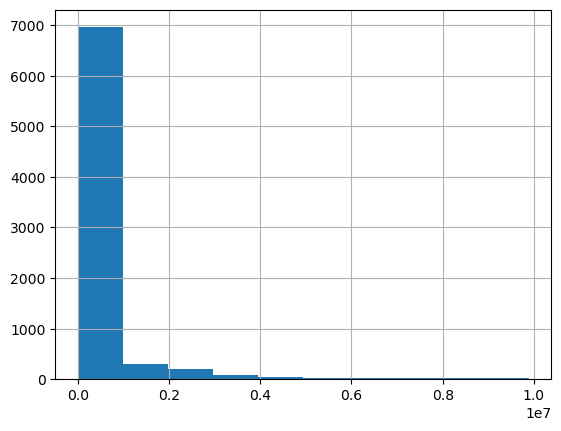

In [51]:
data.sales.hist()

With such a large range, the sales are getting automatically transformed in an unreadable way for visualizations.

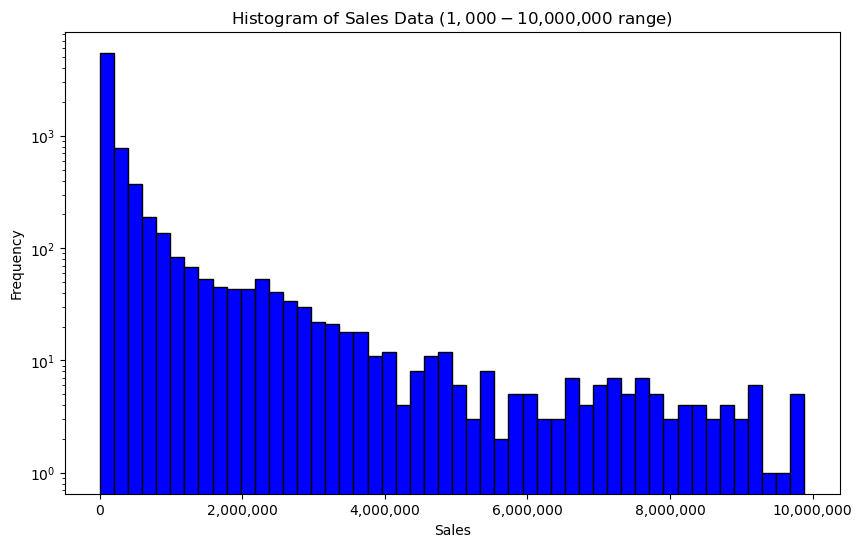

In [52]:
# Filter the data to include only sales within the specified range
filtered_sales = data['sales'][(data['sales'] >= 1000) & (data['sales'] <= 10000000)]

plt.figure(figsize=(10, 6))
plt.hist(filtered_sales, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Sales Data ($1,000 - $10,000,000 range)')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.yscale('log')  # Log scale for better visualization

# Set x-axis to show actual values with custom formatting
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.show()


Fitting the sales in a range gives it a much more readable view. There is a huge skew of data, so log trasformation is appropriate.

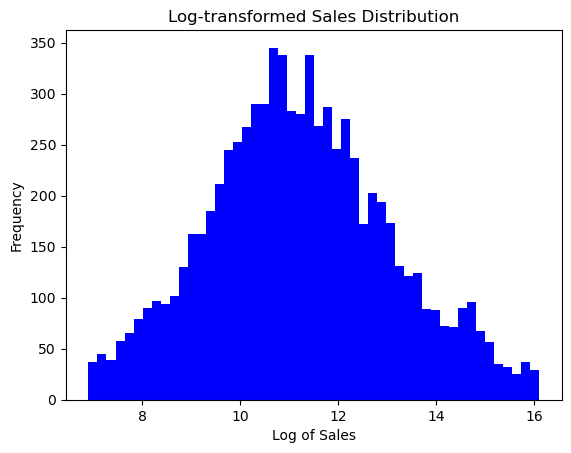

In [53]:
# Apply log transformation to sales data
data['sales_log'] = np.log1p(filtered_sales)
plt.hist(data['sales_log'], bins=50, color = 'blue')
plt.xlabel('Log of Sales')
plt.ylabel('Frequency')
plt.title('Log-transformed Sales Distribution')
plt.show()


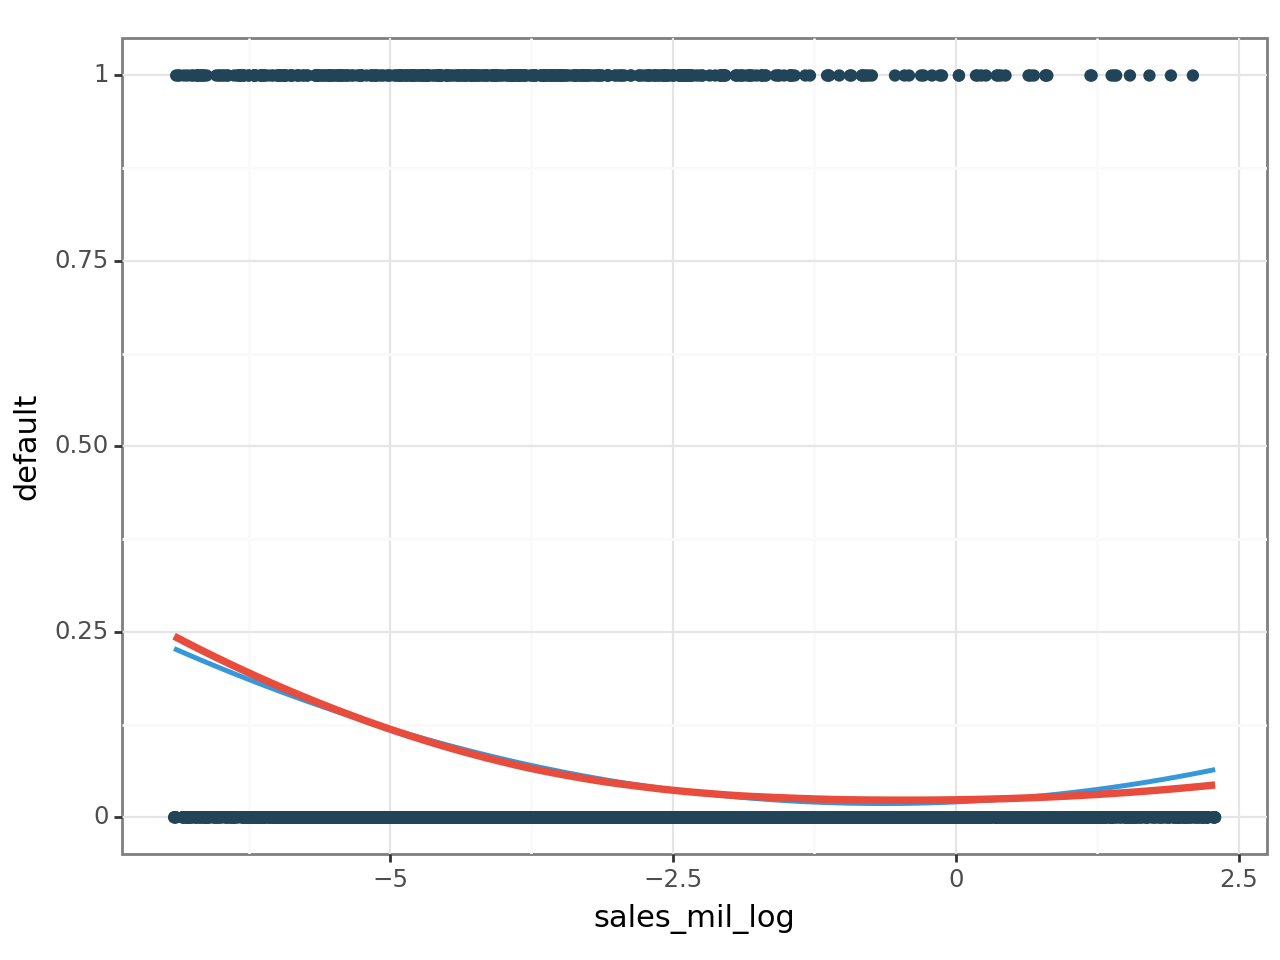

<Figure Size: (640 x 480)>

In [54]:
# Plotting the logarithmic sales and company statuses with linear regression and lowess

ggplot(data, aes(x="sales_mil_log", y="default")) + geom_point(
    color="#214459"
) + geom_smooth(
    method="lm", formula="y ~ x + I(x**2)", color="#3498db", se=False  # Assuming #3498db as a placeholder color
) + geom_smooth(
    method="loess", color="#e74c3c", se=False, size=1.5, span=0.9  # Assuming #e74c3c as a placeholder color
) + labs(
    x="sales_mil_log", y="default"
) + theme_bw()


## 1.6 *Model Building*
---

### 1.6.1 *Define Variable Sets*
---

#### Main Firm Variables
---

In [55]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales",
    "share_eq",
    "subscribed_cap",
]

#### Further financial variables
---

In [56]:
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]

#### Financial Ratios
---

In [57]:
financial_ratios = [
    "gross_profit_margin",
    "net_profit_margin",
    "return_on_equity",
    "debt_equity_ratio",
    "current_ratio",
    "quick_ratio",
    "return_on_assets"
]

#### Flag Variables
---

In [58]:
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)

#### Growth Variables
---

d1 = [
    "d1_sales_mil_log",
    "d1_sales_mil_log_sq",
    "flag_low_d1_sales_mil_log",
    "flag_high_d1_sales_mil_log",
]

#### Human capital related variables
---

In [59]:
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "foreign_management",
]

#### Firms history related variables
---

In [76]:
firm = ["age",
        "age2",
        "new",
        "C(m_region_loc)",
        "C(urban_m)"]

#### Interactions for logit, LASSO
---

interactions1 = [
    "C(ind2_cat)*age",
    "C(ind2_cat)*age2",
    "C(ind2_cat)*sales_mil_log",
    "C(ind2_cat)*ceo_age",
    "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*female",
    "C(ind2_cat)*C(urban_m)"
]

In [61]:
# Adding interactions with log sales 
interactions2 = [
    "sales_mil_log*age",
    "sales_mil_log*female",
    "sales_mil_log*profit_loss_year_pl",
    "sales_mil_log*foreign_management",
]

In [62]:
# Adding further interactions with our financial ratios
interactions3 = [
    "sales_mil_log*gross_profit_margin",
    "sales_mil_log*net_profit_margin",
    "sales_mil_log*return_on_equity",
    "sales_mil_log*debt_equity_ratio",
    "sales_mil_log*current_ratio",
    "sales_mil_log*quick_ratio",
    "sales_mil_log*return_on_assets"
]

# Adding further interactions which can affect sales of the firm
interactions4 = [
    "female*foreign_management",
    "ceo_young*share_eq_bs",
    "ceo_young*extra_profit_loss_pl",
    "origin*foreign_management",
    "ceo_young*year"
]

### 1.6.2 *Model Setups*
---

#### Simple Logit Models
---

#### Markdown for the original models and variables

M1 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "profit_loss_year_pl",
    "C(ind2_cat)",
]
M2 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "curr_liab_bs ",
    "curr_liab_bs_flag_high ",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management"
]
M3 = ["sales_mil_log", "sales_mil_log_sq"] + firm + engvar
M4 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + hr
    + qualityvars
    + financial_ratios
)
M5 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + hr
    + qualityvars
    + financial_ratios
    + interactions2
)

In [75]:
M1 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "profit_loss_year_pl"
]
M2 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "curr_liab_bs ",
    "curr_liab_bs_flag_high ",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management"
]
M3 = ["sales_mil_log", "sales_mil_log_sq"] + firm + engvar
M4 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + hr
    + qualityvars
    + financial_ratios
)
M5 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + hr
    + qualityvars
    + financial_ratios
    + interactions2
)

#### Logit+LASSO
---

#### Markdown for the original lasso model and variables
logit_lasso_vars = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + engvar
    + engvar2
    + engvar3
    + hr
    + firm
    + qualityvars
    + financial_ratios
    + interactions2
)

In [64]:
logit_lasso_vars = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + engvar
    + engvar2
    + engvar3
    + hr
    + firm
    + qualityvars
    + financial_ratios
    + interactions2
)

#### CART and RF (no interactions, no modified features)
---

In [65]:
rfvars = (
    ["sales_mil", "d1_sales_mil_log"]
    + rawvars
    + hr
    + firm
    + qualityvars
    + financial_ratios
)

# ***2. Predictive Models***
---

## 2.1 *Linear Probability Models*
---

In [66]:
ols_modelx2 = smf.ols("default~" + "+".join(M2), data).fit(cov_type="HC1")
ols_modelx2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                default   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     23.54
Date:                Mon, 26 Feb 2024   Prob (F-statistic):           3.32e-44
Time:                        21:10:12   Log-Likelihood:                 524.54
No. Observations:                7704   AIC:                            -1027.
Df Residuals:                    7693   BIC:                            -950.6
Df Model:                          10                                         
Covariance Type:                  HC1                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0699      0.014      5.015      0.000       0.043       0.097
sales_mil_log               0.0062      0.003      1.937      0.053   -7.27e-05       0.012
sales_mil_log_sq            0.0044      0.001      5.963      0.000       0.003       0.006
profit_loss_year_pl        -0.0219      0.016     -1.327      0.184      -0.054       0.010
fixed_assets_bs            -0.0394      0.011     -3.561      0.000      -0.061      -0.018
share_eq_bs                -0.0224      0.011     -1.982      0.048      -0.045      -0.000
curr_liab_bs               -0.0138      0.015     -0.946      0.344      -0.042       0.015
curr_liab_bs_flag_high      0.0715      0.017      4.178      0.000       0.038       0.105
curr_liab_bs_flag_error    -0.0346      0.014     -2.431      0.015      -0.062      -0.007
age                        -0.0023      0.000     -5.146      0.000      -0.003      -0.001
foreign_management          0.0229      0.009      2.638      0.008       0.006       0.040
==============================================================================
Omnibus:                     5468.363   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            57222.983
Skew:                           3.506   Prob(JB):                         0.00
Kurtosis:                      14.362   Cond. No.                         623.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [67]:
logit_modelx2 = smf.logit("default~" + "+".join(M2), data).fit()

         Current function value: 0.197548
         Iterations: 35


C:\Users\iandr\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


In [68]:
logit_modelx2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                 7704
Model:                          Logit   Df Residuals:                     7693
Method:                           MLE   Df Model:                           10
Date:                Mon, 26 Feb 2024   Pseudo R-squ.:                  0.1007
Time:                        21:10:14   Log-Likelihood:                -1521.9
converged:                      False   LL-Null:                       -1692.4
Covariance Type:            nonrobust   LLR p-value:                 3.293e-67
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.9900      0.236    -12.676      0.000      -3.452      -2.528
sales_mil_log              -0.0623      0.075     -0.827      0.408      -0.210       0.085
sales_mil_log_sq            0.0413      0.011      3.673      0.000       0.019       0.063
profit_loss_year_pl        -0.1687      0.148     -1.136      0.256      -0.460       0.122
fixed_assets_bs            -0.7166      0.201     -3.564      0.000      -1.111      -0.323
share_eq_bs                -0.2620      0.149     -1.761      0.078      -0.554       0.030
curr_liab_bs               -0.0389      0.245     -0.159      0.874      -0.519       0.441
curr_liab_bs_flag_high      0.7172      0.211      3.406      0.001       0.305       1.130
curr_liab_bs_flag_error   -14.1629   2454.087     -0.006      0.995   -4824.084    4795.759
age                        -0.0474      0.009     -5.515      0.000      -0.064      -0.031
foreign_management          0.5253      0.145      3.621      0.000       0.241       0.810
===========================================================================================
"""

In [69]:
logit_modelx2.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                default
Method:                          dydx
At:                           overall
===========================================================================================
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
sales_mil_log              -0.0032      0.004     -0.826      0.409      -0.011       0.004
sales_mil_log_sq            0.0021      0.001      3.668      0.000       0.001       0.003
profit_loss_year_pl        -0.0085      0.008     -1.136      0.256      -0.023       0.006
fixed_assets_bs            -0.0363      0.010     -3.547      0.000      -0.056      -0.016
share_eq_bs                -0.0133      0.008     -1.759      0.078      -0.028       0.002
curr_liab_bs               -0.0020      0.012     -0.159      0.874      -0.026       0.022
curr_liab_bs_flag_high      0.0363      0.011      3.395      0.001       0.015       0.057
curr_liab_bs_flag_error    -0.7168    124.204     -0.006      0.995    -244.153     242.719
age                        -0.0024      0.000     -5.443      0.000      -0.003      -0.002
foreign_management          0.0266      0.007      3.599      0.000       0.012       0.041
===========================================================================================
"""

## 2.2 *Predict probabilities with logit and Lasso with CV*
---

In [70]:
data_train = data.copy()

In [71]:
# Setting the number of folds to 5
k = KFold(n_splits=5, shuffle=True, random_state=42)

### 2.2.1 *Cross validate logit models*
---

Set up X-vars

In [72]:
# Setting up X-vars
logit_model_vars = [M1, M2, M3, M4, M5]

*Setting up Logit model object*

Setting the C value to a very high value turns off regularization, allowing the logistic model to fit the training data as closely as possible

In [73]:
# Setting the parameter to a very high value
C_value_logit = [1e20]

In [77]:
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "default~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)
    
    
    LRCV_brier = LogisticRegressionCV(
        # No regularization
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        # Setting the toleralization for the optimization
        tol=1e-7,
        random_state=42,
    )
    
    # Fitting the Brier model to the training data and naming the models
    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculating RMSE on test for each fold
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )

PatsyError: Error evaluating factor: NameError: name 'ind2_cat' is not defined
    default~sales_mil_log+sales_mil_log_sq+profit_loss_year_pl+C(ind2_cat)
                                                               ^^^^^^^^^^^

In [ ]:
# Checking out the RMSE values
pd.DataFrame(CV_RMSE_folds)

### 2.2.2 *Logit + LASSO*
---

In [87]:
# Adding the logit lasso variables to our model equation
model_equation = "default~" + "+".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

In [88]:
# Scaling the variables
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

In [89]:
# Setting up a list of C values
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [
    1 / (l * n_obs) for l in lambdas
]  # Cs are the inverse of regularization strength --> smaller C values mean stronger regularization

In [90]:
# Performing another linear regression with CV
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    # Using LASSO as penalty
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

# Fitting the LASSO model to the training data
logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)

In [91]:
# Summarizing the regularization parameters
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.001623,0.252698
1,0.046416,0.003496,0.236666
2,0.021544,0.007531,0.228362
3,0.010000,0.016225,0.225155
4,0.004642,0.034956,0.224497
5,0.002154,0.075311,0.224642
6,0.001000,0.162253,0.224587
7,0.000464,0.349564,0.224873
8,0.000215,0.753113,0.225316
9,0.000100,1.622534,0.225729


In [92]:
# Returning the index of the minimum mean cv score as we will need it later
best_lambda_i = cv_summary_lasso["mean_cv_score"].idxmin()

In [93]:
# Calculating the RMSE of the models
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

In [94]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5,LASSO
0,0.236005,0.235817,0.255126,0.235150,0.234497,0.233810
1,0.221742,0.220554,0.234673,0.221593,0.220805,0.218850
2,0.232635,0.230961,0.249650,0.232763,0.231640,0.230994
3,0.226180,0.222374,0.477344,0.477344,0.477344,0.219539
4,0.224321,0.221604,0.245400,0.224267,0.223368,0.218808


## 2.3 *AUC, Calibration Curve, Confusion Matrix, ROC*
---

0. Calculate AUC for folds

In [95]:
# First, we calculate AUC for logits
CV_AUC_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "default~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_auc = LogisticRegressionCV(
        # No regularization
        Cs=C_value_logit,
        cv=k,
        refit=True,
        # Setting the scoring to ROC and AUC
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )
    
    # Fitting the model to the training set
    logit_models["M" + str(i + 1)] = LRCV_auc.fit(X_train, y_train)

    # Calculating AUC on test for each fold
    CV_AUC_folds["M" + str(i + 1)] = logit_models["M" + str(i + 1)].scores_[1].ravel()

In [96]:
# Now, we calculate AUC for Lasso
logLasso_auc = LogisticRegressionCV(
    # Using the C values
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)

# Fitting the Lasso model to the training data
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)

# Computing AUC for the LASSO model based on CV scores 
CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][
    :, cv_summary_lasso["mean_cv_score"].idxmin()
]

In [97]:
# Creating a data frame for model fits
model_fits = pd.DataFrame(logit_models, index=["Model fit"]).T

summary = (
    model_fits["Model fit"]
    .apply(lambda x: x.n_features_in_)
    .to_frame(name="Number of Coefficients")
)

summary.loc["LASSO", "Number of Coefficients"] = len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

summary["CV RMSE"] = pd.DataFrame(CV_RMSE_folds).T.mean(axis=1)
summary["CV AUC"] = pd.DataFrame(CV_AUC_folds).T.mean(axis=1)

In [98]:
# Calculating the number of coefficients for the LASSO model
sum(x != 0 for x in model_fits.loc["LASSO"].values[0].coef_[0].tolist())

21

In [99]:
len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

21

In [100]:
# Summarizing the model performance
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,4,0.228177,0.693651
M2,11,0.226262,0.741309
M3,26,0.292439,0.580852
M4,75,0.278223,0.709488
M5,79,0.277531,0.710520
LASSO,21,0.224400,0.770937


### Take best model and estimate RMSE on holdout  

We will go with M2 since it is a simpler model with one of the lowest RMSE


there were a ton of errors coming up about legnths and infinte values. the following three code blocks "correct" those errors. but, the real issue is probably something deeper in the code that could be fixed and resolve the issue. 

In [101]:
# Preapring the holdout sample by creating a design matrix of independent variables
best_logit = logit_models["M2"]

# Constructing a formula string for the model
model_equation = "default~" + "+".join(M2)

# Ignoring the design matrix for the dependent variable as it is not needed
_, X_holdout = patsy.dmatrices(model_equation, hold_out_sample)

In [102]:
hold_out_sample["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout)[:, 1]

round(rmse(hold_out_sample["best_logit_pred_proba"], hold_out_sample["default"]), 3)

0.207

### a) Calibration curve

how well do estimated vs actual event probabilities relate to each other?


In [103]:
# Checking the missing values
print(hold_out_sample['best_logit_pred_proba'].isnull().sum())
print(hold_out_sample['default'].isnull().sum())


0
0


In [104]:
# Dropping missing values for probabilities and defaulted companies
hold_out_sample = hold_out_sample.dropna(subset=['best_logit_pred_proba', 'default'])
# Example: Imputing with 0 or a suitable value for 'best_logit_pred_proba'
hold_out_sample['best_logit_pred_proba'] = hold_out_sample['best_logit_pred_proba'].fillna(0)


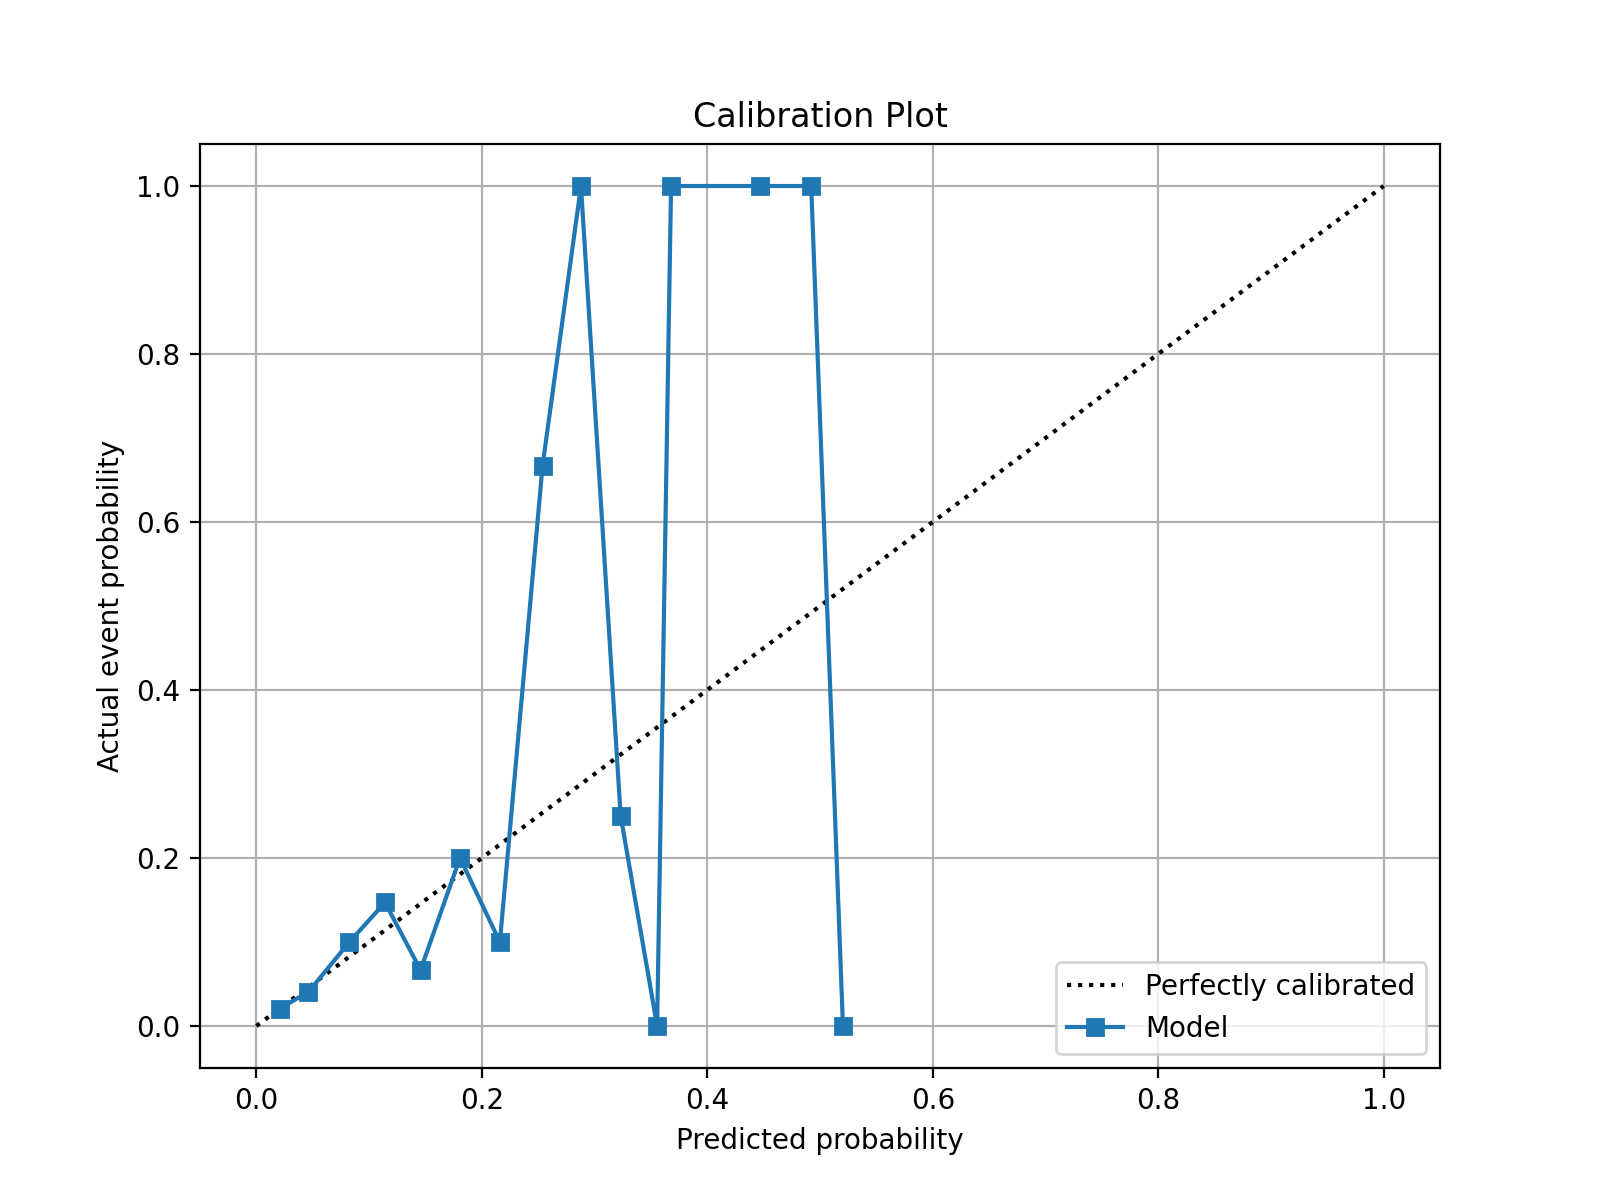

In [105]:
# Plotting the calibration curve
create_calibration_plot(
    data=hold_out_sample,
    file_name="figure-1-logit-lasso-calibration",
    prob_var="best_logit_pred_proba",
    actual_var="default",
    y_lab="Actual event probability",
    n_bins=30,
    breaks=None
)

something is wrong with the calibration, we will need to go back through everything and try to figure it out

### b) Confusion table with different tresholds

- The deault is setting the threshold 0.5 which is used to convert probabilities to binary classes

In [106]:
# Making predictions on the hold out dataset using the trained regression model 
logit_class_prediction = best_logit.predict(X_holdout)

# Counting the unique values in the logit class prediction
values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0], " (no default): ", counts[0])
print(values[1], " (default): ", counts[1])

0.0  (no default):  1005
1.0  (default):  1


**Confusion matrix:** summarize different type of errors and successfully predicted cases

- positive = "yes": explicitly specify the positive case

In [107]:
# Setting up the confusion matrix
cm_object1 = confusion_matrix(
    hold_out_sample["default"], logit_class_prediction, labels=[0, 1]
)

# Naming the columns and rows
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actual no default", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm1

,Predicted no default,Predicted default
Actual no default,956,1
Actual default,49,0


In [108]:
# Applying different thresholds

# Setting 0.1: The lower we set the threshold, the more FP and less FN we get
holdout_prediction = np.where(hold_out_sample["best_logit_pred_proba"] < 0.1, 0, 1)
cm_object1b = confusion_matrix(
    hold_out_sample["default"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actual no default", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm1b

,Predicted no default,Predicted default
Actual no default,886,71
Actual default,32,17


In [109]:
# Calculating the mean threshold value
mean_predicted_default_prob = np.mean(hold_out_sample["best_logit_pred_proba"])
round(mean_predicted_default_prob, 3)

0.048

In [110]:
# Comparing the predicted probability with the threshold value
# Probabilities less then the threshold: negative class (0)
# Probabilitites more than the threshold: positive class (1)
holdout_prediction = np.where(
    hold_out_sample["best_logit_pred_proba"] < mean_predicted_default_prob, 0, 1
)
cm_object2 = confusion_matrix(
    hold_out_sample["default"], holdout_prediction, labels=[0, 1]
)

# Creating the data frame for the confusion matrix
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actual no default", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm2

,Predicted no default,Predicted default
Actual no default,686,271
Actual default,18,31


### c) Visualize ROC (with thresholds in steps) on holdout

- To compare multiple thresholds
- Calculating the true positive rates (TPR) and the false positive rates (FPR)

In [111]:
# First, discrete ROC (with thresholds in steps) on holdout
# Setting the threshold from 0.05 until 0,76 with a 0.05 step size
thresholds = np.arange(0.05, 0.76, 0.05)

#thresholds = sorted(np.geomspace(0.95, 0.05, num=17)) # set these treshold values to get even points in the plot
cm = dict()

true_positive_rates = []
false_positive_rates = []
holdout_prediction = []

# Looping through the thresholds
for thr in thresholds:
    
    holdout_prediction = np.where(hold_out_sample["best_logit_pred_proba"] < thr, 0, 1)
    # Specifying the labels as 0,1 to ensure the order of the classes
    cm_thr = confusion_matrix(hold_out_sample["default"], holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    # Calculating the Sensitivity
    true_positive_rates.append(tp / (tp + fn))
    # Calculating the (1-Specificity)
    false_positive_rates.append(fp / (fp + tn))

In [112]:
# Creating a DataFrame to plot the values
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)
tpr_fpr_for_thresholds

,thresholds,true_positive_rates,false_positive_rates
0,0.05,0.632653,0.265413
1,0.10,0.346939,0.074190
2,0.15,0.224490,0.035528
3,0.20,0.163265,0.016719
4,0.25,0.122449,0.007315
5,0.30,0.081633,0.006270
6,0.35,0.061224,0.002090
7,0.40,0.040816,0.001045
8,0.45,0.020408,0.001045
9,0.50,0.000000,0.001045


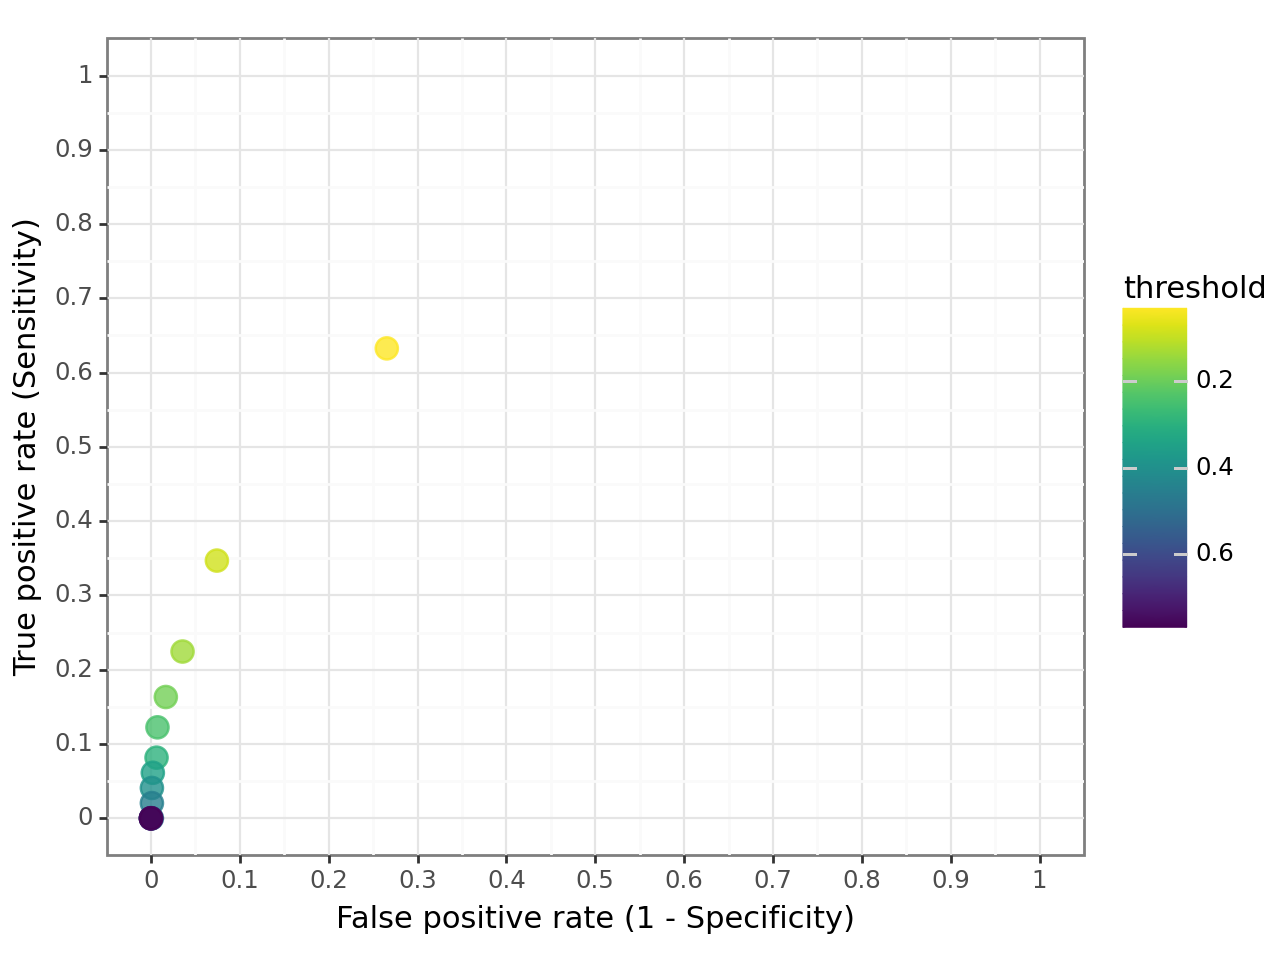

<Figure Size: (640 x 480)>

In [113]:
# Plotting the ROC curve
(
    ggplot(
        tpr_fpr_for_thresholds,
        aes(x="false_positive_rates", y="true_positive_rates", color="thresholds"),
    )
    + labs(
        x="False positive rate (1 - Specificity)", y="True positive rate (Sensitivity)"
    )
    + geom_point(size=4, alpha=0.8)
    + scale_color_continuous(trans="reverse", name="threshold")
    + scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + theme_bw()
    + theme(legend_position="right")
)

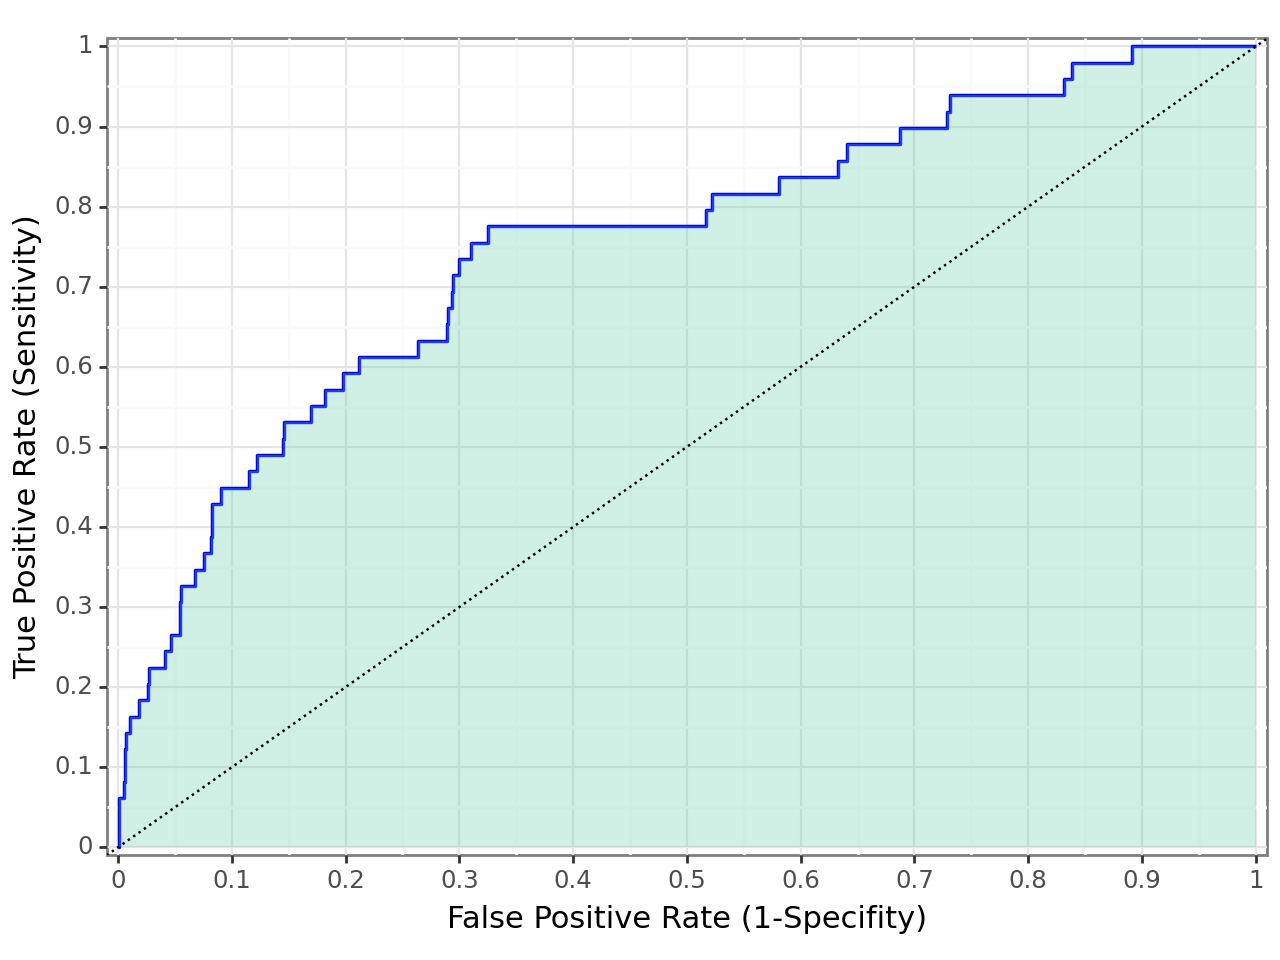

<Figure Size: (640 x 480)>

In [114]:
# Plotting the continous ROC curve
color = 'red'
create_roc_plot(hold_out_sample["default"], hold_out_sample["best_logit_pred_proba"])

## 2.4 *We have a loss function*
---

By setting the FP to 1 and the FN to 10, we can define a cost function for our binary classification. This cost function means that the FN is considered 10 times more costly than the FP. False negative cases in our analysis mean that we predicted no default, but the firm defaulted, resulting in a bigger loss.

In [115]:
# Setting the FP to 1 and the FN 10 to define a cost function
FP = 1
FN = 10
cost = FN / FP

In [116]:
# Calculating the positive classes
prevelance = y_train.sum() / len(y_train)

- Calculating the positive classes (above the threshold) representing the fraction of positive instances in the training data
- This ratio provides insight into class distribution and imbalance
- This can be used for model evaluation later

We are drawing an ROC Curve and finding the optimal threshold with the loss function:

- In other words, this step is part of a cross-validation procedure for selecting optimal thresholds for binary classification models and evaluating their performance using expected loss
- The optimal cut-off is the threshold that maximizes the distance to the identity (diagonal) line
- We are iterating through:
     1. Models
     2. Folds

In [117]:
# Initialization of dictionairies
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

# Iterating over each model
for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []
    
    # If the model is not LASSO, it prepares the design matrices and sets the index for cv to 0
    if model_name != "LASSO":
        _, X = patsy.dmatrices("default ~" + "+".join(logit_model_vars[i]), data_train)
        X = pd.DataFrame(X)
        c_index = 0
        
    # LASSO model: X is normalized_logitvars and sets the best lambda as the index
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    
    # We iterate these models over each fold of the CV
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["default"].iloc[test_index]
        # Generating fold prediction for the current fold using the specified model
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        # Calculating the ROC curve and calculating the optimal threshold based on a loss function
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1
    # Storing best thresholds and the expected loss
    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # Storing best thresholds and the expected loss for Fold 5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )
    
    # Storing all ROC curve estimates for Fold 5
    fold5_all_coords[model_name] = all_coords

In [118]:
# Summarizing the average expected loss, the threshold and th expected loss for Fold 5
summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
summary_with_lossfnc["Threshold for Fold5"] = fold5_threshold.values()
summary_with_lossfnc["Avg expected loss"] = expected_loss_cv.values()
summary_with_lossfnc["Expected loss for Fold5"] = fold5_expected_loss.values()


In [119]:
summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,M1,0.084765,0.080330,0.453139,0.439610
1,M2,0.085052,0.094792,0.429257,0.424675
2,M3,inf,inf,0.553089,0.551948
3,M4,0.174363,0.088066,0.446907,0.417532
4,M5,0.158428,0.069468,0.443533,0.424675
5,LASSO,0.084866,0.077287,0.410173,0.386364


**the inf average of optimal thresholds is problematic**

Create loss plot based on Fold5 in CV 

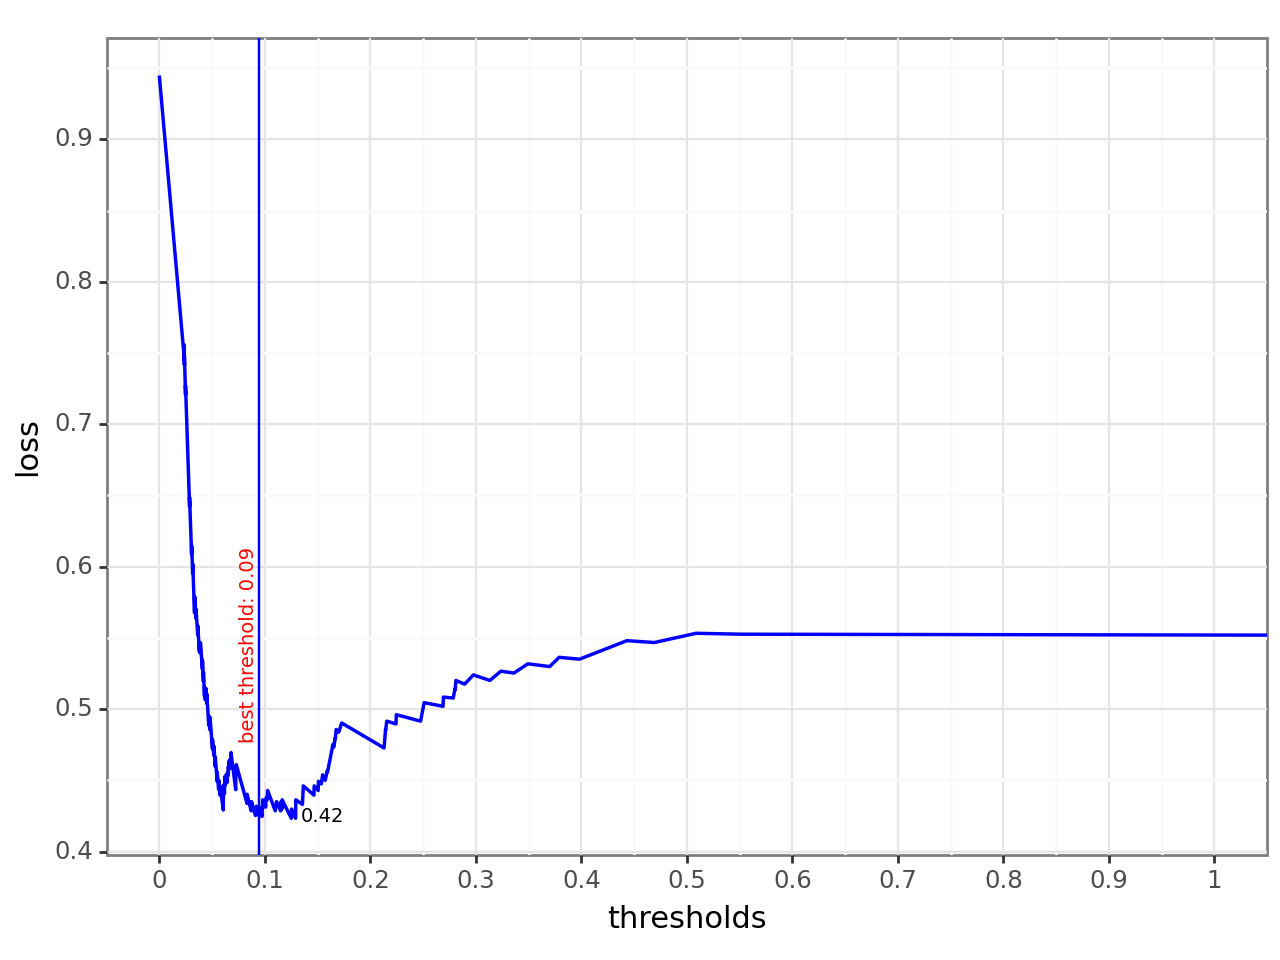

<Figure Size: (640 x 480)>

In [120]:
# Creating the loss plot based on based on Fold5 in CV
model_to_plot = "M2"  # select model to plot
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

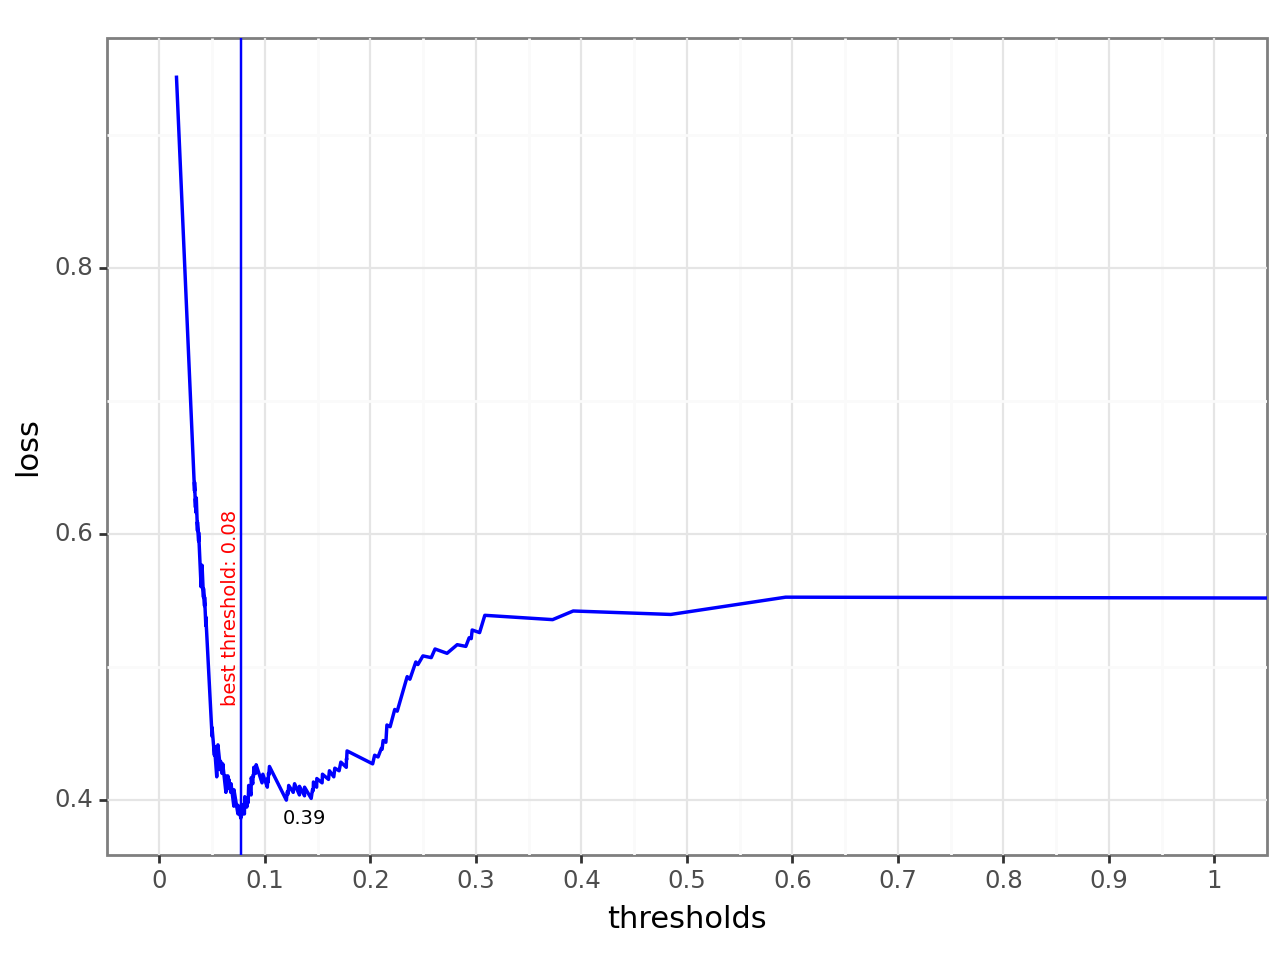

<Figure Size: (640 x 480)>

In [121]:
# I checked LASSO out of curiosity
model_to_plot = "LASSO"  # select model to plot
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

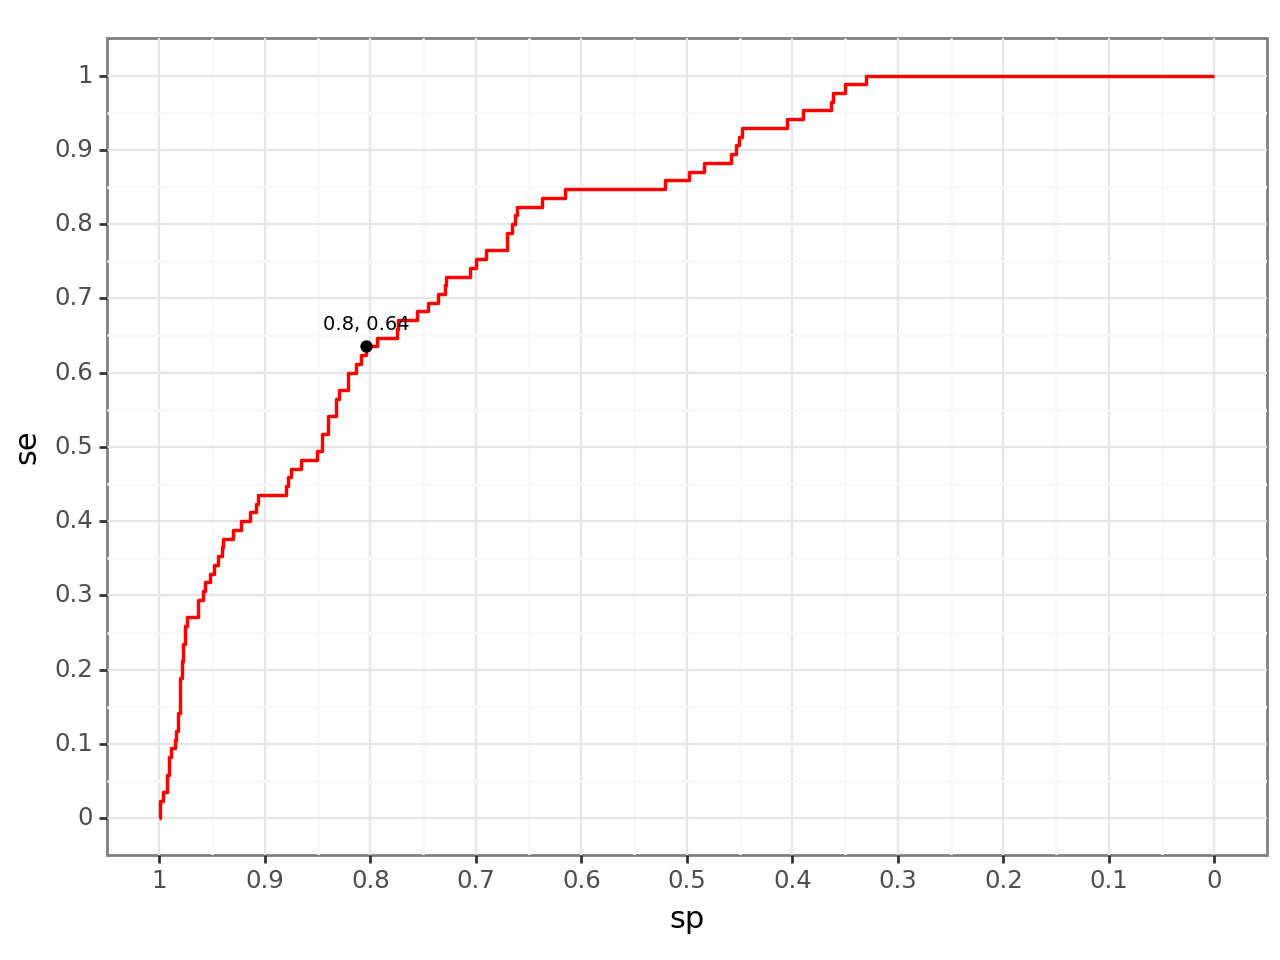

<Figure Size: (640 x 480)>

In [122]:
# Creating ROC plot based on Fold 5 in CV with optimal threshold
create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)


#### Checking the chosen model's (M4) holdout expected loss

In [123]:
# Finding the best optimal threshold
best_logit_optimal_treshold = best_thresholds_cv["M4"]

# Applying the optimal threshold on the holdout sample
holdout_treshold = np.where(
    hold_out_sample["best_logit_pred_proba"] < best_logit_optimal_treshold, 0, 1
)
# If the predicted probability is less than the threshold --> assigns 0 (no default)

# Computing the confusion matrix using the true labels and the predicted labels
tn, fp, fn, tp = confusion_matrix(
    hold_out_sample["default"], holdout_treshold, labels=[0, 1]
).ravel()

# Calculating the expected loss on the holdout sample
# len() computes the expected loss on the holdout sample using fp and fn weighted by their respective costs
# Then it divides the total loss by the total number of observations in the holdout sample
expected_loss_holdout = (fp * FP + fn * FN) / len(hold_out_sample["default"])
round(expected_loss_holdout, 3)

0.413

#### Confusion matrix on the holdout sample

In [124]:
# Confusion matrix on the holdout set with the holdout_threshold
cm_object3 = confusion_matrix(hold_out_sample["default"], holdout_treshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actual no default", "Actual default"],
    columns=["Predicted no default", "Predicted default"],
)
cm3

,Predicted no default,Predicted default
Actual no default,932,25
Actual default,39,10


# ***3. PREDICTION WITH RANDOM FOREST***
---

Handling missing values before using parts matrixes with forward filling (ffill)
Forward filling replaces missing values with the last observed value in the column
data_train_filled = data_train.fillna(method='ffill') 

Creating the design matrices for random forest (default as target and rfvars as predictor variables)
Variables will be extracted from the filled training set
y_train, rfvars_train = patsy.dmatrices("default~" + "+".join(rfvars), data_train_filled)


In [126]:
# Creating design matrices for RF, variables extracted from the training set
y_train, rfvars_train = patsy.dmatrices("default~" + "+".join(rfvars), data_train)

# Creating design matrices for RF, variables extracted from the holdout sample
y_holdout, rfvars_holdout = patsy.dmatrices("default~" + "+".join(rfvars), hold_out_sample)

## 3.1 *Graph Decision Tree*
---

<Figure size 640x480 with 0 Axes>

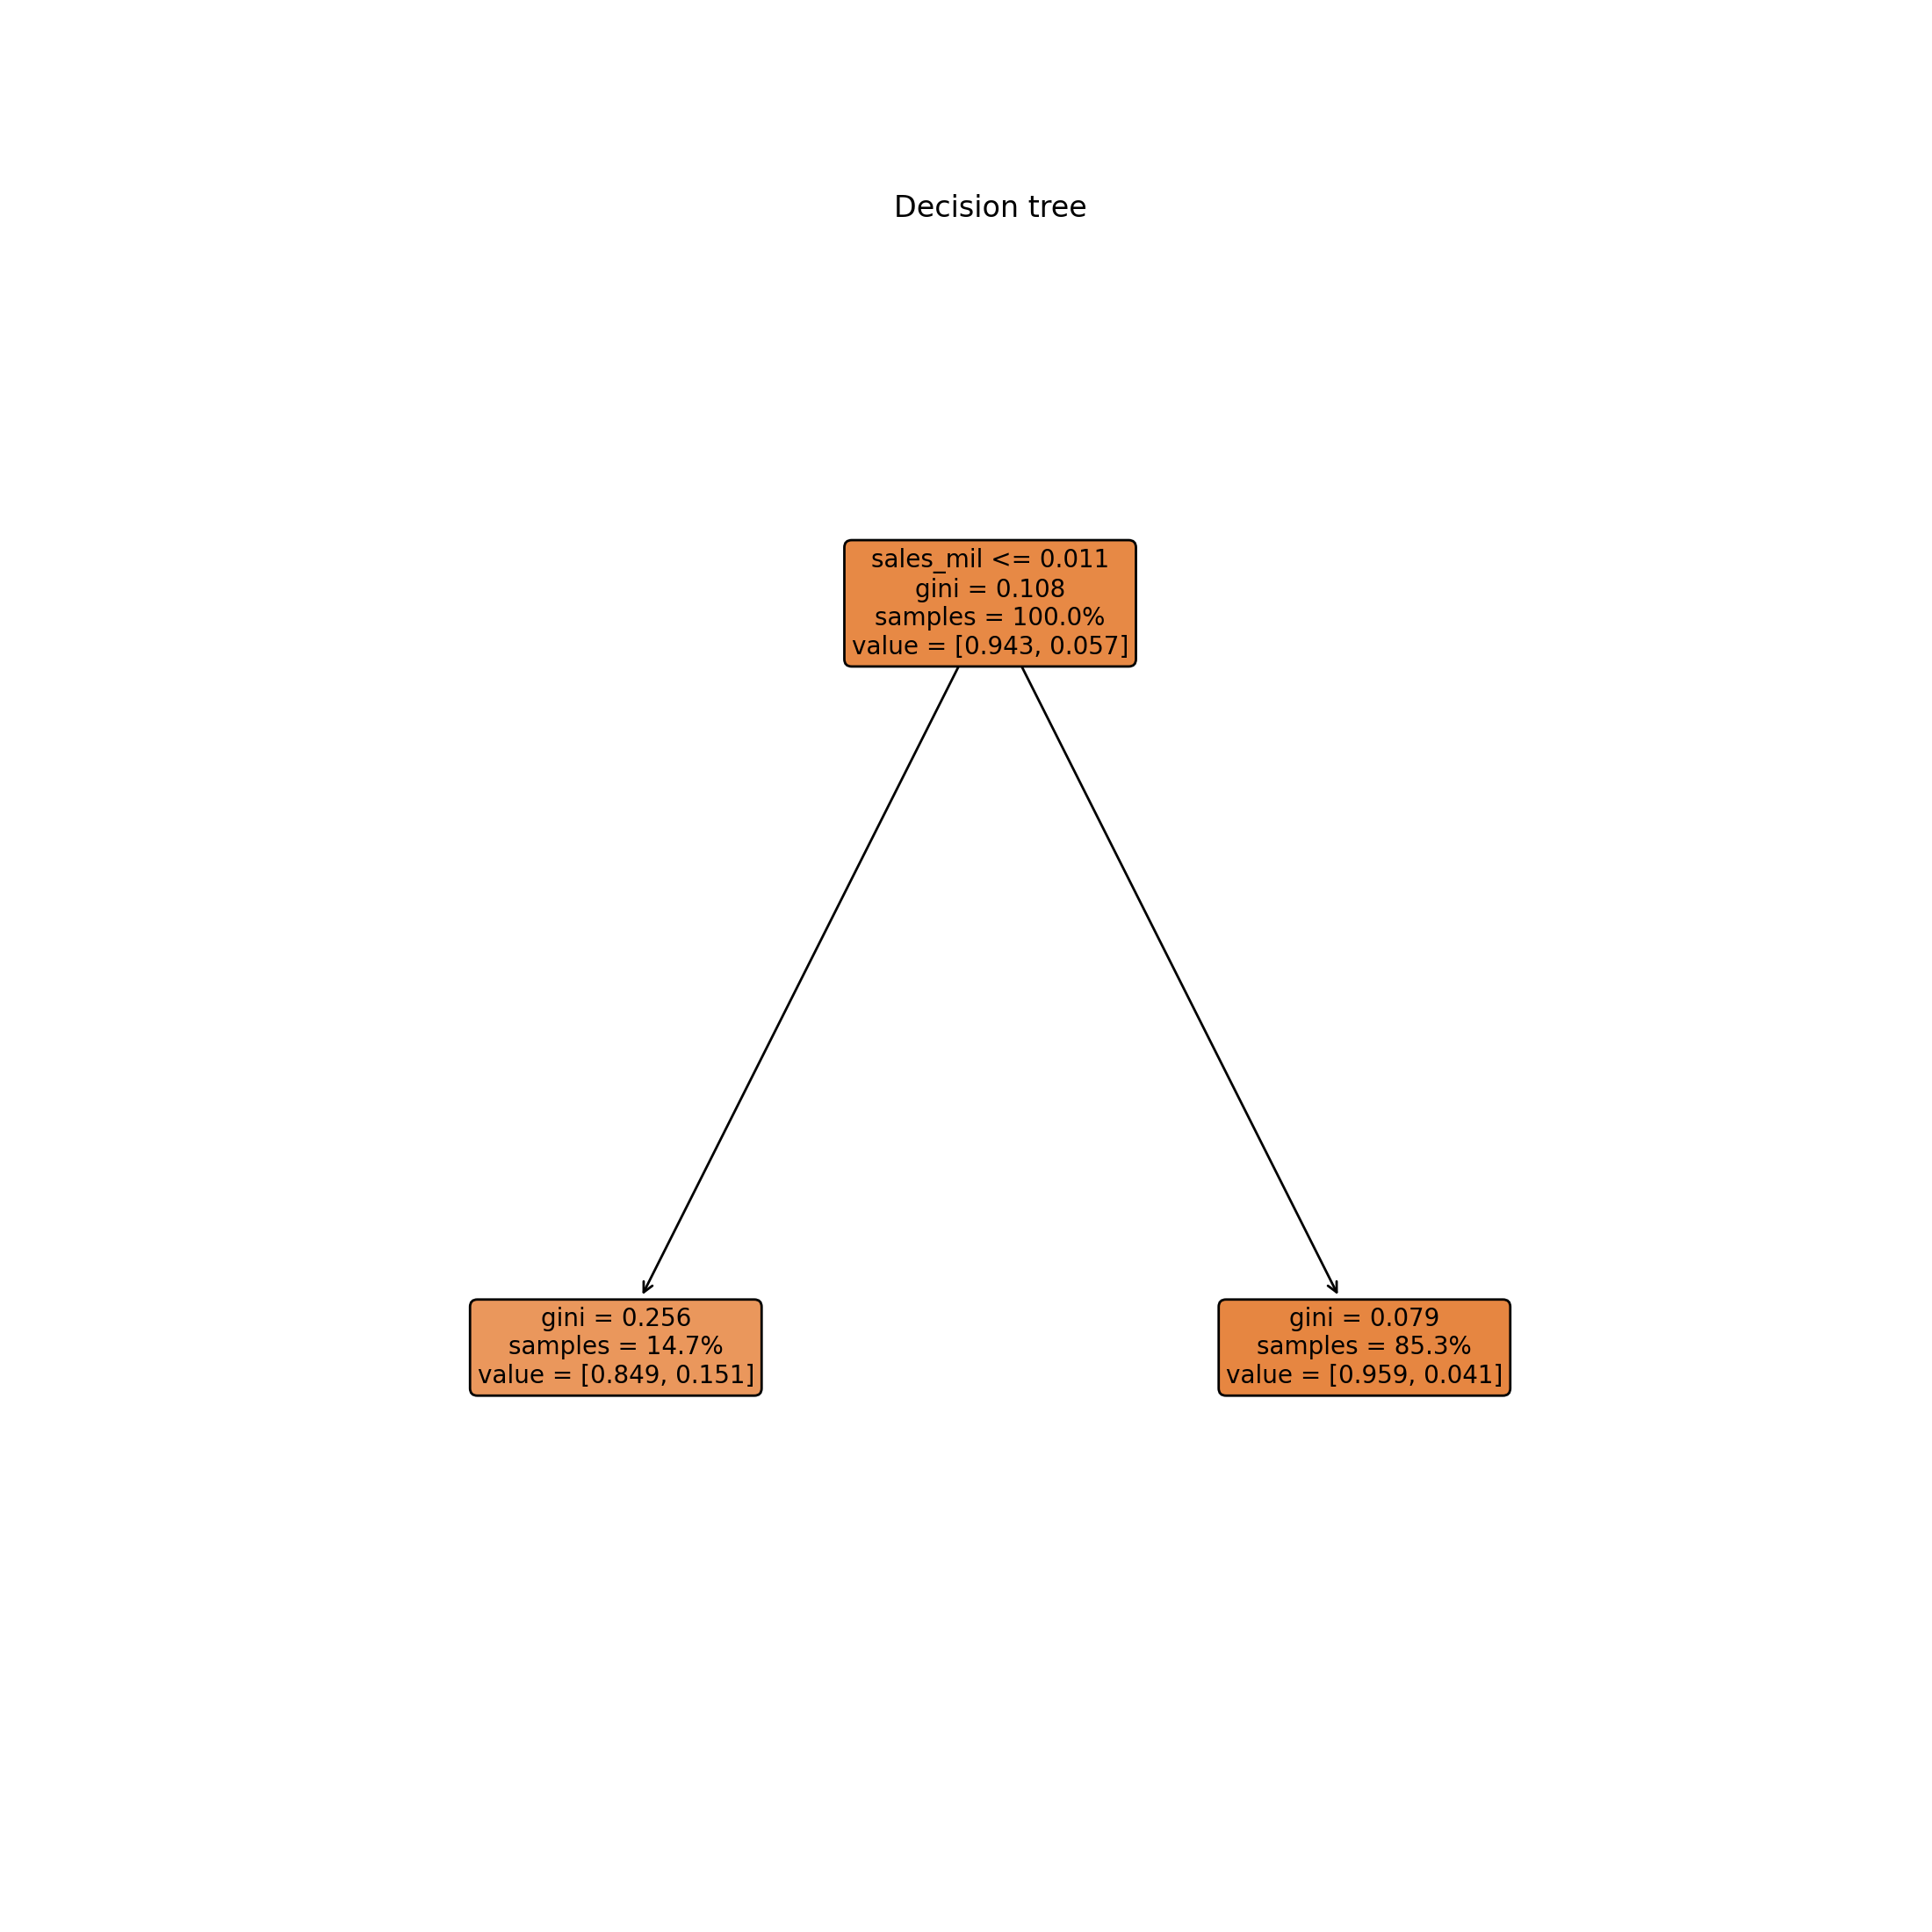

In [127]:
# Selecting the data for visualization
# We can definitely select different variables as well if we want a more in-depth tree
data_for_graph = data_train[["sales_mil", "profit_loss_year", "foreign_management"]]

# Training the decision tree classifier on the selected subset features and the target variable
rf_for_graph = DecisionTreeClassifier(
    ccp_alpha=0.0028, min_samples_leaf=100, max_depth=3, random_state=41
).fit(data_for_graph, y_train)

# Plotting the decision tree
plt.figure()
plt.figure(figsize=(11, 11))
plot_tree(
    rf_for_graph,
    feature_names=list(data_for_graph.columns),
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10,
)
plt.title("Decision tree")
plt.show()


## 3.2 *Probability Forest*
---

### Hyperparameter tuning/GridSearch

- For each combination of hyperparameters, RF algo is fitting multiple decision trees and evaluates their performance based on gini, our specified criteria
- Ratio of 1's in each tree refers to the proportion of samples with the positive label in each individual decision tree
- Averaging over trees refers to aggregating the predictions made by each individual decision tree in the ensemble to produce a final prediction

In [131]:
# Creating a grid to search through the specified hyperparameter combinations during model training
grid = {
    "max_features": [5, 6, 7],
    "criterion": ["gini"],
    "min_samples_split": [11, 16],
} 

In [132]:
# Setting a 5 Fold cross-validation
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,
    cv=k,
    refit="roc_auc",
    scoring=["roc_auc", "neg_brier_score"],
)

In [ ]:
###############################################################

# Let's put a timer here

###############################################################

In [133]:
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

In [134]:
prob_forest_cv_results = pd.DataFrame(
    {
        "max_features": prob_forest_fit.cv_results_["param_max_features"],
        "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
        "cv_auc": prob_forest_fit.cv_results_["mean_test_roc_auc"],
        "cv_rmse": np.sqrt(
            prob_forest_fit.cv_results_["mean_test_neg_brier_score"] * -1
        ),
    }
)

prob_forest_cv_results

,max_features,min_samples_split,cv_auc,cv_rmse
0,5,11,0.794943,0.223043
1,5,16,0.791814,0.223094
2,6,11,0.791628,0.223307
3,6,16,0.790150,0.223219
4,7,11,0.792881,0.223595
5,7,16,0.790274,0.223382


In [135]:
best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]
prob_forest_fit.best_params_


{'criterion': 'gini', 'max_features': 5, 'min_samples_split': 11}

In [136]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

In [137]:
summary.loc["RF", "Number of Coefficients"] = "n.a."
summary.loc["RF", "CV RMSE"] = prob_forest_best_results["cv_rmse"].values[0]
summary.loc["RF", "CV AUC"] = prob_forest_best_results["cv_auc"].values[0]
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,4.0,0.228177,0.693651
M2,11.0,0.226262,0.741309
M3,26.0,0.292439,0.580852
M4,75.0,0.278223,0.709488
M5,79.0,0.277531,0.710520
LASSO,21.0,0.224400,0.770937
RF,n.a.,0.223043,0.794943


In [138]:
CV_RMSE_folds["RF"] = np.sqrt(
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)
CV_AUC_folds["RF"] = (
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_roc_auc")
    .loc[lambda x: x["rank_test_roc_auc"] == 1]
    .filter(like="split")
    .values[0]
)

In [139]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.236005,0.235817,0.255126,0.235150,0.234497,0.233810,0.231780
1,0.221742,0.220554,0.234673,0.221593,0.220805,0.218850,0.218687
2,0.232635,0.230961,0.249650,0.232763,0.231640,0.230994,0.225933
3,0.226180,0.222374,0.477344,0.477344,0.477344,0.219539,0.219116
4,0.224321,0.221604,0.245400,0.224267,0.223368,0.218808,0.219401


In [140]:
pd.DataFrame(CV_AUC_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.701572,0.728172,0.600844,0.726753,0.731717,0.761287,0.791559
1,0.714570,0.737369,0.626638,0.745096,0.742278,0.765655,0.801308
2,0.688875,0.743916,0.580753,0.760795,0.766781,0.768416,0.812104
3,0.623449,0.727319,0.555640,0.555640,0.555640,0.755705,0.783048
4,0.739790,0.769768,0.540384,0.759159,0.756184,0.803622,0.786695


In [ ]:
###############################################################

# Let's put a timer here

###############################################################

In [141]:
best_thresholds = list()
expected_loss = list()
rfvars_train = pd.DataFrame(rfvars_train)

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index, :]
    y_fold = data_train["default"].iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index, :]
    y_fold_train = data_train["default"].iloc[train_index]

    prob_forest_best = RandomForestClassifier(
        random_state=42,
        n_estimators=500,
        oob_score=True,
        criterion="gini",
        max_features=best_mtry,
        min_samples_split=best_min_node_size,
    )
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)


In [142]:
expected_loss_cv["RF"] = np.mean(expected_loss)
best_thresholds_cv["RF"] = np.mean(best_thresholds)


In [143]:
rf_summary = pd.DataFrame(
    {
        "CV RMSE": [round(prob_forest_best_results["cv_rmse"].values[0], 3)],
        "CV AUC": [round(prob_forest_best_results["cv_auc"].values[0], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["RF"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["RF"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.223,0.795,0.095,0.095,0.392,0.393


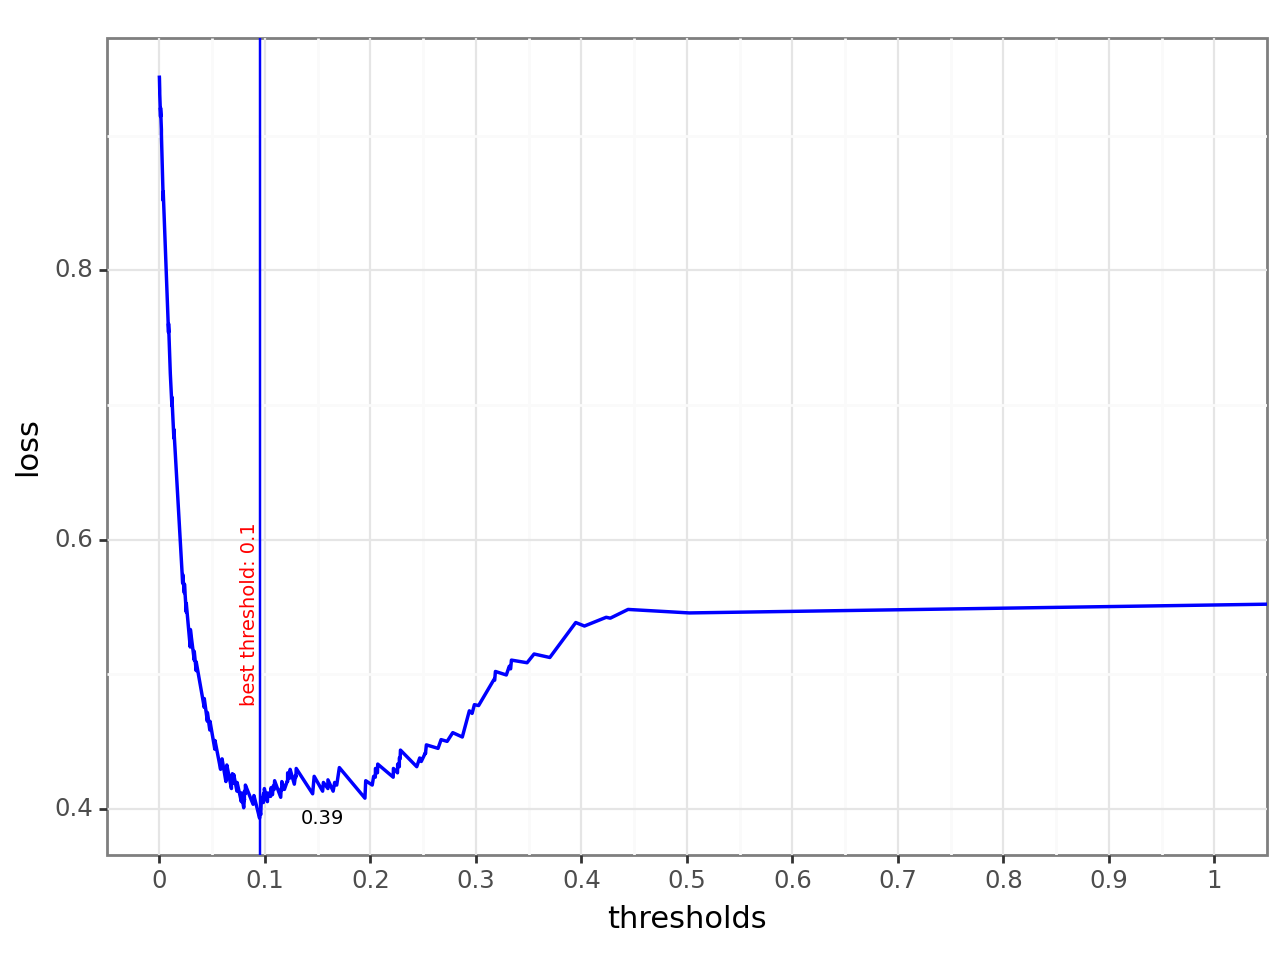

<Figure Size: (640 x 480)>

In [144]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

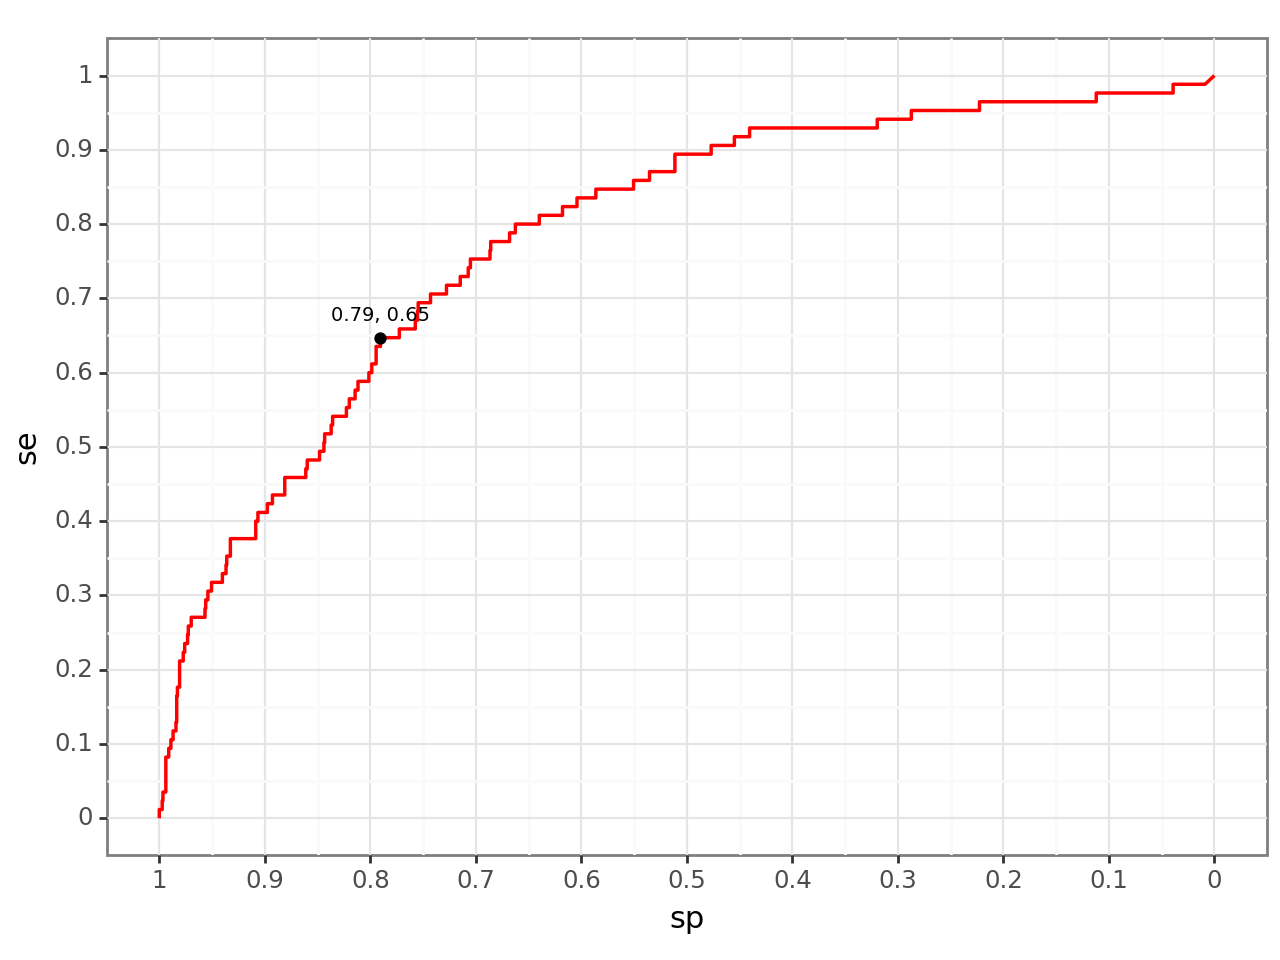

<Figure Size: (640 x 480)>

In [145]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

Take model to holdout and estimate RMSE, AUC and expected loss 

In [146]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)


0.201

ROC AUC  on holdout

In [147]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)


0.83

 Get expected loss on holdout

In [148]:
holdout_treshold = np.where(
    rf_predicted_probabilities_holdout < best_thresholds_cv["RF"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)


0.325

# ***4. Final Results***
---

In [149]:
summary["CV treshold"] = best_thresholds_cv
summary["CV expected Loss"] = expected_loss_cv

In [150]:
summary

,Number of Coefficients,CV RMSE,CV AUC,CV treshold,CV expected Loss
M1,4.0,0.228177,0.693651,0.084765,0.453139
M2,11.0,0.226262,0.741309,0.085052,0.429257
M3,26.0,0.292439,0.580852,inf,0.553089
M4,75.0,0.278223,0.709488,0.174363,0.446907
M5,79.0,0.277531,0.710520,0.158428,0.443533
LASSO,21.0,0.224400,0.770937,0.084866,0.410173
RF,n.a.,0.223043,0.794943,0.095356,0.392394
